In [1]:
import numpy as np
import pandas as pd
import h5py
import os
import glob
from datetime import datetime
from datetime import timedelta
from matplotlib import pyplot as plt
import matplotlib.dates as md
import warnings
from scipy.interpolate import interp2d
from scipy.interpolate import interp1d
from scipy.interpolate import make_interp_spline
warnings.filterwarnings('ignore')
import scipy.ndimage as ndimage
from matplotlib import cm
from matplotlib.colors import LogNorm
from sklearn import preprocessing
import seaborn as sns
from scipy.stats import pearsonr
from scipy import stats

In [2]:
def simple_read(path):
    with open(path) as f:
        first_line = f.readline()
        header_line = int(first_line[0:-2].split(",")[0])-1
        #all_lines = f.readlines()
    data = pd.read_csv(path, sep=',', skiprows=header_line)
    data.columns = [i.strip() for i in data.columns]
    #date = all_lines[5][0:10].split(',')
    #dt = datetime(int(date[0]), int(date[1]), int(date[2]))

    acc = 0
    boo = False
    for letter in path:
        if letter == '2':
            boo = True
        elif boo and letter == '0':
            acc -= 1
            break
        acc += 1
    #print(path[:acc+4], path[acc+4:acc+6], path[acc+6:acc+8])
    dt = datetime(int(path[acc:acc+4]), int(path[acc+4:acc+6]), int(path[acc+6:acc+8]))
    
    for column in data.keys():
        if 'Time' in column:
            data[column] = dt + pd.to_timedelta(data[column], unit='seconds')
    return data.replace(-999999, np.NaN)

In [3]:
filename = "C:/Users/taiwoajayi/Documents/HSRL_2/ACTIVATE-HSRL2_KingAir_20220618_R2.h5"
f = h5py.File(filename, 'r')
day18 = np.array(f["DataProducts"])
day18

array(['1064_aer_dep', '1064_aer_dep_cloud_screened',
       '1064_aer_dep_syst_unc', '1064_bsc', '1064_bsc_Sa',
       '1064_bsc_cloud_screened', '1064_bsr', '1064_bsr_cloud_screened',
       '1064_dep', '1064_dep_cloud_screened', '1064_ext',
       '1064_total_attn_bsc', '355_AOT_above_cloud', '355_AOT_alts',
       '355_AOT_from_bsc_FullRange',
       '355_AOT_from_bsc_FullRange_above_cloud',
       '355_AOT_from_bsc_StandardRange',
       '355_AOT_from_bsc_StandardRange_above_cloud',
       '355_AOT_from_bsc_col_FullRange',
       '355_AOT_from_bsc_col_StandardRange', '355_AOT_hi',
       '355_AOT_hi_col', '355_Sa', '355_aer_dep',
       '355_aer_dep_cloud_screened', '355_aer_dep_syst_unc', '355_bsc',
       '355_bsc_Sa', '355_bsc_cloud_screened', '355_bsr',
       '355_bsr_cloud_screened', '355_dep', '355_dep_cloud_screened',
       '355_ext', '355_extinction_from_backscatter', '355_total_attn_bsc',
       '532_AOT_above_cloud', '532_AOT_alts',
       '532_AOT_from_bsc_FullRange',

In [4]:
#Read AOT cumulative data
AOT_532_hi = np.array(f["DataProducts"]['532_AOT_hi_col'])

In [5]:
#converting to dataframe
data2 = pd.DataFrame(AOT_532_hi)
data2 = data2.T

In [6]:
start_col = 818
end_col = 958
subset = data2.loc[:, start_col:end_col]
subset

,818,819,820,821,822,823,824,825,826,827,...,949,950,951,952,953,954,955,956,957,958
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
638,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
639,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
Day18 = subset.iloc[40:569]
#Day18 = Day18.replace(np.NaN, 0)
Day18

,818,819,820,821,822,823,824,825,826,827,...,949,950,951,952,953,954,955,956,957,958
40,0.111471,0.113743,0.110850,0.111989,0.111783,0.110067,0.108798,0.109902,0.109700,0.108928,...,0.111501,0.113223,0.113926,0.115832,0.116699,0.116264,0.118395,0.119425,0.121371,0.123205
41,0.109804,0.111668,0.108765,0.111236,0.112178,0.110866,0.108135,0.108957,0.108844,0.106773,...,0.113486,0.113362,0.113112,0.113545,0.115554,0.114082,0.117731,0.121567,0.124163,0.127181
42,0.107157,0.107850,0.105167,0.107260,0.108341,0.107502,0.104959,0.105886,0.107239,0.104724,...,0.113970,0.112484,0.112051,0.111290,0.114732,0.113507,0.117133,0.125280,0.128654,0.133052
43,0.108870,0.107695,0.104711,0.105271,0.105986,0.105208,0.102252,0.103386,0.104892,0.104147,...,0.113030,0.111234,0.111161,0.110796,0.114445,0.114534,0.115675,0.124587,0.127930,0.132098
44,0.109292,0.108612,0.106352,0.106070,0.105268,0.104572,0.101305,0.103374,0.104631,0.106254,...,0.113021,0.111659,0.111006,0.112161,0.115237,0.114739,0.115194,0.122012,0.125061,0.128886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
565,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
566,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
first_row = Day18.iloc[0]
last_row = Day18.iloc[-1]
result = first_row - last_row
result

818   NaN
819   NaN
820   NaN
821   NaN
822   NaN
       ..
954   NaN
955   NaN
956   NaN
957   NaN
958   NaN
Length: 141, dtype: float64

In [11]:
res = result.mean()
res

nan

In [10]:
result.std()

nan

In [11]:
DAY18 = simple_read('C:/Users/taiwoajayi/Documents/Extinction/activate-mrg1_hu25_20220618_R0_20230523T125200.ict')
start_index = np.where(DAY18["Time_Start"]==pd.to_datetime("2022-06-18 14:09:00"))
stop_index = np.where(DAY18["Time_Start"]==pd.to_datetime("2022-06-18 14:33:00"))
DAY18_subset =DAY18[start_index[0][0]:stop_index[0][0]]
DAY18_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Pressure_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc450_submicron_ZIEMBA,...,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,SSA_450nm_ZIEMBA,SSA_550nm_ZIEMBA,SSA_700nm_ZIEMBA,SSA_amb_550nm_ZIEMBA,stdPT_ZIEMBA
7425,2022-06-18 14:09:00,2022-06-18 14:09:01,36.589500,-71.990803,110.135,428.715,25.275,987.185,19.110,27.790,...,0.020,1.035,1.450,1.445,NaN,0.9595,NaN,NaN,NaN,1.1215
7426,2022-06-18 14:09:01,2022-06-18 14:09:02,36.590250,-71.991516,110.155,426.230,25.270,987.250,17.185,27.195,...,0.130,1.200,1.450,1.450,NaN,0.9620,NaN,NaN,NaN,1.1210
7427,2022-06-18 14:09:02,2022-06-18 14:09:03,36.591026,-71.992186,109.965,424.700,25.290,987.330,17.100,26.575,...,0.165,1.250,1.445,1.440,NaN,0.9620,NaN,NaN,NaN,1.1210
7428,2022-06-18 14:09:03,2022-06-18 14:09:04,36.591824,-71.992808,109.535,415.290,25.335,987.780,17.105,26.190,...,0.165,1.250,1.425,1.415,NaN,0.9605,NaN,NaN,NaN,1.1210
7429,2022-06-18 14:09:04,2022-06-18 14:09:05,36.592643,-71.993383,109.055,410.005,25.360,988.055,18.650,25.315,...,0.125,1.190,1.410,1.400,NaN,0.9560,NaN,NaN,NaN,1.1210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8860,2022-06-18 14:32:55,2022-06-18 14:32:56,36.634224,-71.921855,7949.270,24787.600,-24.560,370.935,NaN,7.275,...,NaN,NaN,-0.670,NaN,0.755,0.3705,0.184,NaN,NaN,2.4860
8861,2022-06-18 14:32:56,2022-06-18 14:32:57,36.634412,-71.923239,7954.260,24800.800,-24.595,370.705,NaN,2.700,...,NaN,NaN,-0.670,2.550,0.810,0.3595,NaN,0.2070,NaN,2.4875
8862,2022-06-18 14:32:57,2022-06-18 14:32:58,36.634602,-71.924625,7959.290,24817.600,-24.645,370.415,NaN,0.710,...,NaN,NaN,-0.670,2.400,0.905,0.3535,NaN,0.2225,NaN,2.4885
8863,2022-06-18 14:32:58,2022-06-18 14:32:59,36.634793,-71.926012,7964.380,24832.700,-24.695,370.160,NaN,0.755,...,NaN,NaN,-0.670,2.290,1.075,0.3485,NaN,0.2370,NaN,2.4895


In [12]:
#reindexed_data = DAY18_subset.reset_index(drop=True)
#reindexed_data

In [13]:
DAY18_subset.GPS_Altitude_THORNHILL.min()

105.925

In [14]:
list(DAY18_subset)

['Time_Start',
 'Time_Stop',
 'Latitude_THORNHILL',
 'Longitude_THORNHILL',
 'GPS_Altitude_THORNHILL',
 'Pressure_Altitude_THORNHILL',
 'Static_Air_Temp_THORNHILL',
 'Static_Pressure_THORNHILL',
 'Sc550_submicron_amb_ZIEMBA',
 'Sc450_submicron_ZIEMBA',
 'Sc550_submicron_ZIEMBA',
 'Sc700_submicron_ZIEMBA',
 'RH_Sc_submicron_ZIEMBA',
 'Abs470_total_ZIEMBA',
 'Abs532_total_ZIEMBA',
 'Abs660_total_ZIEMBA',
 'Ext532_submicron_amb_ZIEMBA',
 'Ext532_submicron_ZIEMBA',
 'gamma550_ZIEMBA',
 'fRH550_RH20to80_ZIEMBA',
 'AEscatAMB_450to700nm_ZIEMBA',
 'AEscat_450to700nm_ZIEMBA',
 'AEabsDRY_470to660nm_ZIEMBA',
 'SSA_450nm_ZIEMBA',
 'SSA_550nm_ZIEMBA',
 'SSA_700nm_ZIEMBA',
 'SSA_amb_550nm_ZIEMBA',
 'stdPT_ZIEMBA']

In [15]:
var = 'Ext532_submicron_amb_ZIEMBA'

In [16]:
#Binning data by altitude and getting average ext per altitude bin
nbins = 100
bins = np.linspace(DAY18_subset.GPS_Altitude_THORNHILL.min(), DAY18_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
output = []

In [17]:
for n, alt_min in enumerate(bins[:-1]):

    alt_max = bins[n+1]
    
    #Get mean extinction of altitude bin
    mean_ext = DAY18_subset.loc[(alt_min < DAY18_subset.GPS_Altitude_THORNHILL) & (DAY18_subset.GPS_Altitude_THORNHILL <= alt_max), var].mean()
    
    #Convert from Mm-1 to m-1
    mean_ext *= 1e-6
    
    #Layer AOT
    layer_aot = mean_ext*(alt_max-alt_min)
    
    #Including in dataframe that we will sum later
    output.append([alt_min, alt_max, layer_aot])

output = pd.DataFrame(output)
output.columns = ['AltMin', 'AltMax', 'Ext']

#Summing ext across altitude bins
print('AOD:', output['Ext'].sum())

AOD: 0.07146612877214145


In [18]:
output['Ext'].std()

0.00041921449503477885

In [19]:
output

,AltMin,AltMax,Ext
0,105.92500,184.56075,0.001605
1,184.56075,263.19650,0.001565
2,263.19650,341.83225,0.001579
3,341.83225,420.46800,0.001608
4,420.46800,499.10375,0.001511
...,...,...,...
95,7576.32125,7654.95700,NaN
96,7654.95700,7733.59275,NaN
97,7733.59275,7812.22850,NaN
98,7812.22850,7890.86425,NaN


In [20]:
hsrl = result.mean()
hsrl

0.10804526771607072

In [21]:
filename17 = "C:/Users/taiwoajayi/Documents/HSRL_2/ACTIVATE-HSRL2_KingAir_20220617_R2.h5"
f17 = h5py.File(filename17, 'r')

In [22]:
AOT_532_hi17 = np.array(f17["DataProducts"]['532_AOT_hi_col'])

In [23]:
data17 = pd.DataFrame(AOT_532_hi17)
data17 = data17.T

In [24]:
data17

,0,1,2,3,4,5,6,7,8,9,...,1165,1166,1167,1168,1169,1170,1171,1172,1173,1174
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
638,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
639,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
start_col17 = 1130
#end_col17 = 1175
subset17 = data17.loc[:, start_col17:]
subset17

,1130,1131,1132,1133,1134,1135,1136,1137,1138,1139,...,1165,1166,1167,1168,1169,1170,1171,1172,1173,1174
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
638,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
639,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
Day17 = subset17.iloc[41:503]
#Day17 = Day17.replace(np.NaN, 0)
Day17

,1130,1131,1132,1133,1134,1135,1136,1137,1138,1139,...,1165,1166,1167,1168,1169,1170,1171,1172,1173,1174
41,0.172554,0.173039,0.169161,0.165353,0.168847,0.161855,0.167909,0.162157,0.162974,0.157865,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
42,0.172952,0.172344,0.169990,0.166037,0.164944,0.160149,0.160881,0.155299,0.156895,0.154811,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
43,0.174592,0.173381,0.171954,0.164868,0.160390,0.157377,0.154717,0.150925,0.152436,0.154779,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
44,0.176456,0.173952,0.169041,0.160044,0.155066,0.152455,0.149678,0.146882,0.149513,0.153701,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
45,0.176163,0.175628,0.170145,0.159786,0.158162,0.155093,0.152825,0.149023,0.151367,0.155277,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,0.022246,0.020575,0.016903,0.014397,0.011205,0.007926,0.006294,0.005074,0.005218,0.004629,...,0.004448,0.003912,0.005042,0.004209,0.005393,0.006844,0.005155,0.0,0.0,0.0
499,0.021448,0.020030,0.016450,0.014283,0.011462,0.008222,0.006821,0.005733,0.005776,0.004504,...,0.005181,0.004131,0.005336,0.004540,0.005253,0.005975,0.004438,0.0,0.0,0.0
500,0.020881,0.019451,0.015501,0.013178,0.010662,0.007402,0.006381,0.005549,0.006024,0.004654,...,0.004055,0.003378,0.004508,0.004346,0.004781,0.005208,0.004310,0.0,0.0,0.0
501,0.020596,0.018794,0.014260,0.011474,0.008835,0.005822,0.005145,0.005168,0.006096,0.005252,...,0.002506,0.002677,0.003467,0.003315,0.003693,0.004003,0.003801,0.0,0.0,0.0


In [27]:
first_row17 = Day17.iloc[0]
last_row17 = Day17.iloc[-1]
result17 = first_row17 - last_row17
result17

1130    0.153734
1131    0.156142
1132    0.156591
1133    0.155504
1134    0.161263
1135    0.156817
1136    0.163176
1137    0.156976
1138    0.156583
1139    0.151890
1140    0.153198
1141    0.155770
1142    0.152292
1143    0.146380
1144    0.146065
1145    0.145595
1146    0.140661
1147    0.142071
1148    0.142578
1149    0.147823
1150    0.146645
1151    0.149803
1152    0.152167
1153    0.153015
1154    0.147724
1155    0.126701
1156    0.101145
1157    0.065661
1158   -0.003996
1159   -0.002700
1160   -0.000902
1161   -0.000972
1162   -0.002109
1163   -0.001841
1164   -0.001355
1165   -0.001865
1166   -0.002807
1167   -0.003468
1168   -0.003355
1169   -0.004289
1170   -0.004853
1171   -0.005394
1172    0.000000
1173    0.000000
1174    0.000000
dtype: float64

In [28]:
result17.mean()


0.08986810542290115

In [29]:
result17.std()

0.07429162995758219

In [30]:
DAY17 = simple_read('C:/Users/taiwoajayi/Documents/Extinction/activate-mrg1_hu25_20220617_R0_20230523T125200.ict')
start17_index = np.where(DAY17["Time_Start"]==pd.to_datetime("2022-06-17 16:20:00"))
stop17_index = np.where(DAY17["Time_Start"]==pd.to_datetime("2022-06-17 16:47:00"))
DAY17_subset =DAY17[start17_index[0][0]:stop17_index[0][0]]
DAY17_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Pressure_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc450_submicron_ZIEMBA,...,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,SSA_450nm_ZIEMBA,SSA_550nm_ZIEMBA,SSA_700nm_ZIEMBA,SSA_amb_550nm_ZIEMBA,stdPT_ZIEMBA
10469,2022-06-17 16:20:00,2022-06-17 16:20:01,32.206574,-65.006772,134.100,184.735,21.905,995.935,14.935,12.975,...,0.305,1.525,-0.230,-0.270,NaN,NaN,NaN,NaN,NaN,1.0990
10470,2022-06-17 16:20:01,2022-06-17 16:20:02,32.206131,-65.005761,133.795,173.170,21.935,996.415,15.045,14.420,...,0.225,1.365,-0.225,-0.260,NaN,NaN,NaN,NaN,NaN,1.0985
10471,2022-06-17 16:20:02,2022-06-17 16:20:03,32.205725,-65.004728,133.485,163.920,21.940,996.745,15.455,14.705,...,0.120,1.180,-0.210,-0.235,NaN,NaN,NaN,NaN,NaN,1.0980
10472,2022-06-17 16:20:03,2022-06-17 16:20:04,32.205357,-65.003676,133.170,169.310,21.930,996.505,14.330,14.170,...,0.020,1.025,-0.180,-0.195,NaN,NaN,NaN,NaN,NaN,1.0985
10473,2022-06-17 16:20:04,2022-06-17 16:20:05,32.205027,-65.002606,132.825,170.890,21.950,996.455,13.950,12.900,...,-0.045,0.935,-0.170,-0.185,NaN,NaN,NaN,NaN,NaN,1.0990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12084,2022-06-17 16:46:55,2022-06-17 16:46:56,32.158601,-65.020304,7639.050,23452.500,-17.335,393.290,NaN,-2.050,...,NaN,NaN,NaN,NaN,1.315,NaN,NaN,NaN,NaN,2.4130
12085,2022-06-17 16:46:56,2022-06-17 16:46:57,32.157293,-65.019563,7645.810,23471.700,-17.400,392.950,NaN,-0.155,...,NaN,NaN,NaN,NaN,1.370,NaN,NaN,NaN,NaN,2.4145
12086,2022-06-17 16:46:57,2022-06-17 16:46:58,32.156002,-65.018778,7652.610,23491.400,-17.450,392.615,NaN,2.160,...,NaN,NaN,NaN,NaN,1.435,NaN,NaN,NaN,NaN,2.4160
12087,2022-06-17 16:46:58,2022-06-17 16:46:59,32.154729,-65.017953,7659.440,23514.200,-17.510,392.220,NaN,3.490,...,NaN,NaN,NaN,NaN,1.420,NaN,NaN,NaN,NaN,2.4180


In [31]:
var17 = 'Ext532_submicron_amb_ZIEMBA'

In [32]:
#Binning data by altitude and getting average ext per altitude bin
nbins17 = 100
bins17 = np.linspace(DAY17_subset.GPS_Altitude_THORNHILL.min(), DAY17_subset.GPS_Altitude_THORNHILL.max(), nbins17+1)
output17 = []

In [33]:
for n, alt_min in enumerate(bins17[:-1]):

    alt_max = bins17[n+1]
    
    #Get mean extinction of altitude bin
    mean_ext17 = DAY17_subset.loc[(alt_min < DAY17_subset.GPS_Altitude_THORNHILL) & (DAY17_subset.GPS_Altitude_THORNHILL <= alt_max), var17].mean()
    
    #Convert from Mm-1 to m-1
    mean_ext17 *= 1e-6
    
    #Layer AOT
    layer_aot17 = mean_ext17*(alt_max-alt_min)
    
    #Including in dataframe that we will sum later
    output17.append([alt_min, alt_max, layer_aot17])

output17 = pd.DataFrame(output17)
output17.columns = ['AltMin', 'AltMax', 'Ext']

#Summing ext across altitude bins
print('AOD:', output17['Ext'].sum())

AOD: 0.09764113987726226


In [34]:
output17['Ext'].std()

0.001685768423991056

In [35]:
output17

,AltMin,AltMax,Ext
0,124.7300,200.1455,0.000989
1,200.1455,275.5610,0.000968
2,275.5610,350.9765,0.000971
3,350.9765,426.3920,0.001097
4,426.3920,501.8075,0.001102
...,...,...,...
95,7289.2025,7364.6180,NaN
96,7364.6180,7440.0335,NaN
97,7440.0335,7515.4490,NaN
98,7515.4490,7590.8645,NaN


In [36]:
filename14 = "C:/Users/taiwoajayi/Documents/HSRL_2/ACTIVATE-HSRL2_KingAir_20220614_R2.h5"
f14 = h5py.File(filename14, 'r')

In [37]:
AOT_532_hi14 = np.array(f14["DataProducts"]['532_AOT_hi_col'])

In [38]:
data14 = pd.DataFrame(AOT_532_hi14)
data14 = data14.T

In [39]:
data14

,0,1,2,3,4,5,6,7,8,9,...,1318,1319,1320,1321,1322,1323,1324,1325,1326,1327
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
638,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
639,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
start_col14 = 1042
end_col14 = 1175
subset14 = data14.loc[:, start_col14:end_col14]
subset14

,1042,1043,1044,1045,1046,1047,1048,1049,1050,1051,...,1166,1167,1168,1169,1170,1171,1172,1173,1174,1175
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
638,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
639,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
Day14 = subset14.iloc[41:602]
#Day14 = Day14.replace(np.NaN, 0)
Day14

,1042,1043,1044,1045,1046,1047,1048,1049,1050,1051,...,1166,1167,1168,1169,1170,1171,1172,1173,1174,1175
41,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111587,0.113660,0.110883,...,0.096372,0.101300,0.102280,0.100823,0.103724,0.107943,0.108438,0.105970,0.104071,0.107796
42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.114174,0.117159,0.113428,...,0.096916,0.102300,0.103333,0.102251,0.104864,0.107663,0.110057,0.106969,0.105576,0.107258
43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.110754,0.113933,0.110078,...,0.095424,0.099826,0.099025,0.097984,0.099486,0.103087,0.105946,0.103526,0.103779,0.104458
44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.107028,0.110259,0.106827,...,0.093737,0.095976,0.094196,0.094708,0.095229,0.100384,0.101944,0.101049,0.102667,0.103893
45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.106688,0.109981,0.108606,...,0.094945,0.094779,0.093571,0.095209,0.095215,0.100166,0.099909,0.101121,0.104427,0.104802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
598,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
599,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [42]:
first_row14 = Day14.iloc[0]
last_row14 = Day14.iloc[-1]
result14 = first_row14 - last_row14
result14

1042    0.000000
1043    0.000000
1044    0.000000
1045    0.000000
1046    0.000000
          ...   
1171    0.107943
1172    0.108438
1173    0.105970
1174    0.104071
1175    0.107796
Length: 134, dtype: float64

In [43]:
result14.mean()

0.0567803418261913

In [44]:
result.std()

0.01750461837491754

In [45]:
DAY14 = simple_read('C:/Users/taiwoajayi/Documents/Extinction/activate-mrg1_hu25_20220614_R0_20230523T125159.ict')
start14_index = np.where(DAY14["Time_Start"]==pd.to_datetime("2022-06-14 16:05:00"))
stop14_index = np.where(DAY14["Time_Start"]==pd.to_datetime("2022-06-14 16:25:00"))
DAY14_subset =DAY14[start14_index[0][0]:stop14_index[0][0]]
#DAYY_subset = DAYY_subset.replace(-888888, 0)
DAY14_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Pressure_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc450_submicron_ZIEMBA,...,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,SSA_450nm_ZIEMBA,SSA_550nm_ZIEMBA,SSA_700nm_ZIEMBA,SSA_amb_550nm_ZIEMBA,stdPT_ZIEMBA
9363,2022-06-14 16:05:00,2022-06-14 16:05:01,30.642555,-64.394685,117.000,-4.915,25.355,1002.560,NaN,12.890,...,NaN,NaN,0.400,0.090,NaN,NaN,NaN,NaN,NaN,1.1045
9364,2022-06-14 16:05:01,2022-06-14 16:05:02,30.641725,-64.395343,117.085,-6.355,25.370,1002.640,NaN,13.250,...,NaN,NaN,0.380,0.090,NaN,NaN,NaN,NaN,NaN,1.1045
9365,2022-06-14 16:05:02,2022-06-14 16:05:03,30.640923,-64.396042,117.190,-5.945,25.370,1002.640,NaN,12.135,...,NaN,NaN,0.375,0.090,NaN,NaN,NaN,NaN,NaN,1.1045
9366,2022-06-14 16:05:03,2022-06-14 16:05:04,30.640148,-64.396780,117.295,0.210,25.345,1002.400,NaN,12.230,...,NaN,NaN,0.355,0.090,NaN,NaN,NaN,NaN,NaN,1.1045
9367,2022-06-14 16:05:04,2022-06-14 16:05:05,30.639403,-64.397555,117.380,-2.085,25.375,1002.530,NaN,12.655,...,NaN,NaN,0.325,0.105,NaN,NaN,NaN,NaN,NaN,1.1045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10558,2022-06-14 16:24:55,2022-06-14 16:24:56,30.850057,-64.439182,8454.590,25842.500,-26.050,353.175,9.2,7.565,...,-0.75,0.35,0.115,-0.390,0.995,0.4940,0.6160,0.6420,0.6520,2.5955
10559,2022-06-14 16:24:56,2022-06-14 16:24:57,30.851471,-64.439393,8461.000,25861.300,-26.100,352.890,NaN,5.745,...,NaN,NaN,0.140,-0.485,1.365,0.4765,0.6200,0.6640,0.6550,2.5970
10560,2022-06-14 16:24:57,2022-06-14 16:24:58,30.852885,-64.439595,8467.420,25888.100,-26.180,352.460,NaN,4.370,...,NaN,NaN,0.140,-0.605,1.735,0.4605,0.6115,0.6895,0.6505,2.5995
10561,2022-06-14 16:24:58,2022-06-14 16:24:59,30.854300,-64.439786,8473.860,25917.100,-26.260,351.990,NaN,3.835,...,NaN,NaN,0.140,-0.705,1.850,0.4440,0.5965,0.6935,0.6440,2.6020


In [46]:
var14 = 'Ext532_submicron_amb_ZIEMBA'

In [47]:
#Binning data by altitude and getting average ext per altitude bin
nbins14 = 100
bins14 = np.linspace(DAY14_subset.GPS_Altitude_THORNHILL.min(), DAY14_subset.GPS_Altitude_THORNHILL.max(), nbins14+1)
output14 = []

In [48]:
for n, alt_min in enumerate(bins14[:-1]):

    alt_max = bins14[n+1]
    
    #Get mean extinction of altitude bin
    mean_ext14 = DAY14_subset.loc[(alt_min < DAY14_subset.GPS_Altitude_THORNHILL) & (DAY14_subset.GPS_Altitude_THORNHILL <= alt_max), var14].mean()
    
    #Convert from Mm-1 to m-1
    mean_ext14 *= 1e-6
    
    #Layer AOT
    layer_aot14 = mean_ext14*(alt_max-alt_min)
    
    #Including in dataframe that we will sum later
    output14.append([alt_min, alt_max, layer_aot14])

output14 = pd.DataFrame(output14)
output14.columns = ['AltMin', 'AltMax', 'Ext']

#Summing ext across altitude bins
print('AOD:', output14['Ext'].sum())

AOD: 0.0634702397690227


In [49]:
output14['Ext'].std()

0.0009496623891347576

In [50]:
output14

,AltMin,AltMax,Ext
0,117.0000,200.6333,NaN
1,200.6333,284.2666,0.001354
2,284.2666,367.8999,0.000902
3,367.8999,451.5332,0.000878
4,451.5332,535.1665,0.001232
...,...,...,...
95,8062.1635,8145.7968,0.001100
96,8145.7968,8229.4301,0.000909
97,8229.4301,8313.0634,0.000977
98,8313.0634,8396.6967,0.000924


In [51]:
filename13 = "C:/Users/taiwoajayi/Documents/HSRL_2/ACTIVATE-HSRL2_KingAir_20220613_R2_L1.h5"
f13 = h5py.File(filename13, 'r')

In [52]:
AOT_532_hi13 = np.array(f13["DataProducts"]['532_AOT_hi_col'])

In [53]:
data13 = pd.DataFrame(AOT_532_hi13)
data13 = data13.T

In [54]:
start_col13 = 1127
end_col13 = 1154
subset13 = data13.loc[:, start_col13:end_col13]
subset13

,1127,1128,1129,1130,1131,1132,1133,1134,1135,1136,...,1145,1146,1147,1148,1149,1150,1151,1152,1153,1154
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
638,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
639,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
Day13 = subset13.iloc[41:335]
Day13 = Day13.replace(np.NaN, 0)
Day13

,1127,1128,1129,1130,1131,1132,1133,1134,1135,1136,...,1145,1146,1147,1148,1149,1150,1151,1152,1153,1154
41,0.070623,0.077302,0.071914,0.073867,0.076315,0.087120,0.094231,0.095646,0.100742,0.113094,...,0.109845,0.112031,0.105418,0.104615,0.112819,0.110415,0.114675,0.114540,0.116771,0.118001
42,0.071524,0.077121,0.068717,0.072127,0.074801,0.084122,0.088250,0.092226,0.100104,0.113585,...,0.108792,0.108967,0.110732,0.108990,0.114084,0.112140,0.119339,0.118072,0.115527,0.117563
43,0.071786,0.075909,0.067641,0.072659,0.077250,0.086396,0.089756,0.095485,0.103259,0.113581,...,0.111988,0.107893,0.115543,0.111976,0.114930,0.113321,0.120829,0.118644,0.111027,0.113122
44,0.075165,0.078293,0.071528,0.077482,0.083180,0.086394,0.090418,0.096243,0.100247,0.106435,...,0.115996,0.113134,0.120347,0.115754,0.114084,0.112040,0.117619,0.113551,0.104905,0.107487
45,0.075908,0.078793,0.074853,0.079584,0.085749,0.086745,0.090392,0.097209,0.096831,0.099651,...,0.116796,0.115172,0.117592,0.114271,0.109869,0.109820,0.112519,0.110059,0.104971,0.110633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,0.004452,0.004815,0.004913,0.008824,0.005231,0.005607,0.007339,0.009150,0.008770,0.009376,...,0.010346,0.008441,0.008988,0.007468,0.008082,0.006905,0.007839,0.007835,0.006155,0.006164
331,0.003780,0.004289,0.003509,0.007835,0.004695,0.004759,0.005626,0.007637,0.007223,0.008672,...,0.009058,0.006248,0.007941,0.008170,0.008365,0.008772,0.010251,0.012376,0.010942,0.009838
332,0.003182,0.004376,0.002462,0.006237,0.004624,0.004755,0.005749,0.007124,0.007020,0.007674,...,0.008812,0.004903,0.006574,0.006817,0.007263,0.007870,0.008846,0.012865,0.012509,0.010266
333,0.003378,0.004959,0.003087,0.005434,0.005653,0.006880,0.006221,0.006525,0.007325,0.006947,...,0.008088,0.004662,0.005207,0.004977,0.006874,0.007027,0.006929,0.010284,0.011050,0.008290


In [56]:
first_row13 = Day13.iloc[0]
last_row13 = Day13.iloc[-1]
result13 = first_row13 - last_row13
result13

1127    0.067069
1128    0.072189
1129    0.068816
1130    0.070326
1131    0.071212
1132    0.079281
1133    0.088199
1134    0.089637
1135    0.093187
1136    0.105305
1137    0.107165
1138    0.106890
1139    0.108907
1140    0.109172
1141    0.115975
1142    0.113396
1143    0.109661
1144    0.109737
1145    0.104473
1146    0.107994
1147    0.101815
1148    0.101690
1149    0.107990
1150    0.104958
1151    0.108332
1152    0.107311
1153    0.108200
1154    0.111445
dtype: float64

In [57]:
result13.mean()

0.09822609613205083

In [58]:
result13.std()

0.015619023449584327

In [59]:
DAY13 = simple_read('C:/Users/taiwoajayi/Documents/Extinction/activate-mrg1_hu25_20220613_R0_L1_20230523T125158.ict')
start13_index = np.where(DAY13["Time_Start"]==pd.to_datetime("2022-06-13 14:30:00"))
stop13_index = np.where(DAY13["Time_Start"]==pd.to_datetime("2022-06-13 14:46:00"))
DAY13_subset =DAY13[start13_index[0][0]:stop13_index[0][0]]
DAY13_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Pressure_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc450_submicron_ZIEMBA,...,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,SSA_450nm_ZIEMBA,SSA_550nm_ZIEMBA,SSA_700nm_ZIEMBA,SSA_amb_550nm_ZIEMBA,stdPT_ZIEMBA
10015,2022-06-13 14:30:00,2022-06-13 14:30:01,32.210354,-65.054053,141.795,27.095,23.865,1001.400,9.180,9.305,...,0.070,1.110,0.850,0.920,NaN,NaN,NaN,NaN,NaN,1.1000
10016,2022-06-13 14:30:01,2022-06-13 14:30:02,32.209934,-65.052981,141.725,31.175,23.835,1001.240,8.750,8.290,...,0.050,1.080,0.865,0.885,NaN,NaN,NaN,NaN,NaN,1.1000
10017,2022-06-13 14:30:02,2022-06-13 14:30:03,32.209541,-65.051894,141.615,24.580,23.830,1001.510,9.355,10.685,...,0.055,1.085,0.880,0.840,NaN,NaN,NaN,NaN,NaN,1.1000
10018,2022-06-13 14:30:03,2022-06-13 14:30:04,32.209173,-65.050793,141.460,17.190,23.855,1001.800,9.720,13.600,...,0.150,1.230,0.885,0.790,NaN,NaN,NaN,NaN,NaN,1.1000
10019,2022-06-13 14:30:04,2022-06-13 14:30:05,32.208832,-65.049680,141.275,20.190,23.840,1001.640,10.595,13.700,...,0.165,1.260,0.890,0.765,NaN,NaN,NaN,NaN,NaN,1.1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10970,2022-06-13 14:45:55,2022-06-13 14:45:56,32.197220,-65.046274,4504.770,13659.500,-0.020,594.015,NaN,0.435,...,NaN,NaN,NaN,NaN,1.285,NaN,0.21602,0.22940,NaN,1.7055
10971,2022-06-13 14:45:56,2022-06-13 14:45:57,32.196954,-65.044914,4514.670,13690.000,-0.115,593.295,NaN,3.665,...,NaN,NaN,NaN,NaN,1.400,NaN,0.20603,0.22384,NaN,1.7070
10972,2022-06-13 14:45:57,2022-06-13 14:45:58,32.196726,-65.043543,4523.980,13720.100,-0.215,592.580,NaN,3.680,...,NaN,NaN,NaN,NaN,1.440,NaN,0.20906,0.21627,NaN,1.7085
10973,2022-06-13 14:45:58,2022-06-13 14:45:59,32.196539,-65.042160,4532.940,13748.700,-0.295,591.910,NaN,-0.205,...,NaN,NaN,NaN,NaN,1.410,NaN,0.22361,0.20780,NaN,1.7100


In [60]:
var13 = 'Ext532_submicron_amb_ZIEMBA'

In [61]:
#Binning data by altitude and getting average ext per altitude bin
nbins13 = 100
bins13 = np.linspace(DAY13_subset.GPS_Altitude_THORNHILL.min(), DAY13_subset.GPS_Altitude_THORNHILL.max(), nbins13+1)
output13 = []

In [62]:
for n, alt_min in enumerate(bins13[:-1]):

    alt_max = bins13[n+1]
    
    #Get mean extinction of altitude bin
    mean_ext13 = DAY13_subset.loc[(alt_min < DAY13_subset.GPS_Altitude_THORNHILL) & (DAY13_subset.GPS_Altitude_THORNHILL <= alt_max), var13].mean()
    
    #Convert from Mm-1 to m-1
    mean_ext13 *= 1e-6
    
    #Layer AOT
    layer_aot13 = mean_ext13*(alt_max-alt_min)
    
    #Including in dataframe that we will sum later
    output13.append([alt_min, alt_max, layer_aot13])

output13 = pd.DataFrame(output13)
output13.columns = ['AltMin', 'AltMax', 'Ext']

#Summing ext across altitude bins
print('AOD:', output13['Ext'].sum())

AOD: 0.07990705929508984


In [63]:
output13['Ext'].std()

0.0010520427784236263

In [64]:
filename13b = "C:/Users/taiwoajayi/Documents/HSRL_2/ACTIVATE-HSRL2_KingAir_20220613_R2_L2.h5"
f13b = h5py.File(filename13b, 'r')

In [65]:
AOT_532_hi13b = np.array(f13b["DataProducts"]['532_AOT_hi_col'])

In [66]:
data13b = pd.DataFrame(AOT_532_hi13b)
data13b = data13b.T

In [67]:
start_col13b = 1112
end_col13b = 1154
subset13b = data13b.loc[:, start_col13b:end_col13b]
subset13b

,1112,1113,1114,1115,1116,1117,1118,1119,1120,1121,...,1145,1146,1147,1148,1149,1150,1151,1152,1153,1154
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
638,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
639,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
Day13b = subset13b.iloc[41:335]
Day13b = Day13b.replace(np.NaN, 0)
Day13b

,1112,1113,1114,1115,1116,1117,1118,1119,1120,1121,...,1145,1146,1147,1148,1149,1150,1151,1152,1153,1154
41,0.133499,0.136259,0.140262,0.145047,0.140137,0.145791,0.141242,0.138633,0.135525,0.137351,...,0.136635,0.128755,0.126034,0.122619,0.118534,0.115635,0.106647,0.060244,0.0,0.0
42,0.141171,0.142893,0.144829,0.148075,0.144292,0.148412,0.142879,0.138067,0.137521,0.140210,...,0.138214,0.129370,0.127774,0.121745,0.116777,0.111906,0.104878,0.059710,0.0,0.0
43,0.143581,0.142446,0.144765,0.142563,0.141113,0.143317,0.138892,0.136728,0.139042,0.141516,...,0.130557,0.123293,0.120803,0.113900,0.109553,0.105653,0.103995,0.058481,0.0,0.0
44,0.140366,0.138838,0.145653,0.142079,0.139861,0.140572,0.138113,0.139275,0.141330,0.142639,...,0.121410,0.115617,0.111464,0.103772,0.100066,0.099558,0.101873,0.058261,0.0,0.0
45,0.139277,0.137931,0.142671,0.141281,0.136726,0.138891,0.139966,0.144268,0.145593,0.145433,...,0.118127,0.111238,0.107277,0.101090,0.099414,0.101454,0.106558,0.061744,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,0.002700,0.001535,0.003929,0.003152,0.002447,0.002040,0.003140,0.005170,0.003101,0.004676,...,0.012363,0.013060,0.010675,0.010399,0.009647,0.007246,0.006964,0.007137,0.0,0.0
331,0.002117,0.000026,0.002266,0.001196,0.000376,0.001290,0.003405,0.005884,0.006149,0.007713,...,0.008089,0.008558,0.005940,0.007515,0.007143,0.007322,0.008309,0.008669,0.0,0.0
332,0.003531,0.000490,0.002402,0.000739,0.000411,0.002887,0.003518,0.006309,0.006971,0.009525,...,0.006007,0.005170,0.002722,0.005160,0.004788,0.005597,0.006829,0.008773,0.0,0.0
333,0.004126,0.001538,0.003803,0.002136,0.001949,0.005287,0.004861,0.006419,0.005624,0.008932,...,0.007475,0.006219,0.005372,0.007005,0.006750,0.006992,0.008000,0.010059,0.0,0.0


In [69]:
first_row13b = Day13b.iloc[0]
last_row13b = Day13b.iloc[-1]
result13b = first_row13b - last_row13b
result13b

1112    0.128905
1113    0.131722
1114    0.133110
1115    0.140488
1116    0.135434
1117    0.138285
1118    0.133269
1119    0.131774
1120    0.131161
1121    0.128668
1122    0.128933
1123    0.126938
1124    0.128121
1125    0.126900
1126    0.123672
1127    0.123522
1128    0.123303
1129    0.123536
1130    0.132738
1131    0.133619
1132    0.136969
1133    0.136993
1134    0.131798
1135    0.126810
1136    0.119147
1137    0.116317
1138    0.112323
1139    0.110098
1140    0.118946
1141    0.119751
1142    0.124611
1143    0.126156
1144    0.123692
1145    0.126803
1146    0.120909
1147    0.118692
1148    0.115715
1149    0.112261
1150    0.108873
1151    0.098715
1152    0.049956
1153    0.000000
1154    0.000000
dtype: float64

In [70]:
result13b.mean()

0.11766588248830286

In [71]:
result13b.std()

0.029967120958400296

In [72]:
DAY13b = simple_read('C:/Users/taiwoajayi/Documents/Extinction/activate-mrg1_hu25_20220613_R0_L2_20230523T125158.ict')
start13b_index = np.where(DAY13b["Time_Start"]==pd.to_datetime("2022-06-13 19:46:00"))
stop13b_index = np.where(DAY13b["Time_Start"]==pd.to_datetime("2022-06-13 20:09:00"))
DAY13b_subset =DAY13b[start13b_index[0][0]:stop13b_index[0][0]]
#DAYY_subset = DAYY_subset.replace(-888888, 0)
DAY13b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Pressure_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc450_submicron_ZIEMBA,...,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,SSA_450nm_ZIEMBA,SSA_550nm_ZIEMBA,SSA_700nm_ZIEMBA,SSA_amb_550nm_ZIEMBA,stdPT_ZIEMBA
10610,2022-06-13 19:46:00,2022-06-13 19:46:01,32.251226,-65.007304,106.13,-92.470,24.700,1005.880,NaN,8.675,...,NaN,NaN,0.605,0.895,NaN,NaN,NaN,NaN,NaN,1.0980
10611,2022-06-13 19:46:01,2022-06-13 19:46:02,32.250414,-65.006555,105.59,-79.165,24.680,1005.410,NaN,8.150,...,NaN,NaN,0.560,0.855,NaN,NaN,NaN,NaN,NaN,1.0985
10612,2022-06-13 19:46:02,2022-06-13 19:46:03,32.249605,-65.005808,106.45,-55.360,24.620,1004.580,NaN,8.380,...,NaN,NaN,0.500,0.815,NaN,NaN,NaN,NaN,NaN,1.0995
10613,2022-06-13 19:46:03,2022-06-13 19:46:04,32.248799,-65.005062,108.91,-36.300,24.565,1003.920,NaN,4.835,...,NaN,NaN,0.480,0.795,NaN,NaN,NaN,NaN,NaN,1.1000
10614,2022-06-13 19:46:04,2022-06-13 19:46:05,32.247996,-65.004323,112.60,-30.565,24.550,1003.770,NaN,3.700,...,NaN,NaN,0.415,0.790,NaN,NaN,NaN,NaN,NaN,1.1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11985,2022-06-13 20:08:55,2022-06-13 20:08:56,32.290180,-64.996666,4558.09,13794.600,0.615,589.975,NaN,1.610,...,NaN,NaN,NaN,NaN,1.325,NaN,NaN,NaN,NaN,1.7215
11986,2022-06-13 20:08:56,2022-06-13 20:08:57,32.289203,-64.997413,4565.53,13817.600,0.565,589.425,NaN,1.625,...,NaN,NaN,NaN,NaN,1.235,NaN,NaN,NaN,NaN,1.7225
11987,2022-06-13 20:08:57,2022-06-13 20:08:58,32.288204,-64.998124,4572.98,13843.900,0.505,588.785,NaN,1.645,...,NaN,NaN,NaN,NaN,1.180,NaN,NaN,NaN,NaN,1.7240
11988,2022-06-13 20:08:58,2022-06-13 20:08:59,32.287185,-64.998799,4580.36,13865.500,0.450,588.260,NaN,0.170,...,NaN,NaN,NaN,NaN,1.190,NaN,NaN,NaN,NaN,1.7255


In [73]:
var13b = 'Ext532_submicron_amb_ZIEMBA'

In [74]:
#Binning data by altitude and getting average ext per altitude bin
nbins13b = 100
bins13b = np.linspace(DAY13b_subset.GPS_Altitude_THORNHILL.min(), DAY13b_subset.GPS_Altitude_THORNHILL.max(), nbins13b+1)
output13b = []

In [75]:
for n, alt_min in enumerate(bins13b[:-1]):

    alt_max = bins13b[n+1]
    
    #Get mean extinction of altitude bin
    mean_ext13b = DAY13b_subset.loc[(alt_min < DAY13b_subset.GPS_Altitude_THORNHILL) & (DAY13b_subset.GPS_Altitude_THORNHILL <= alt_max), var13b].mean()
    
    #Convert from Mm-1 to m-1
    mean_ext13b *= 1e-6
    
    #Layer AOT
    layer_aot13b = mean_ext13b*(alt_max-alt_min)
    
    #Including in dataframe that we will sum later
    output13b.append([alt_min, alt_max, layer_aot13b])

output13b = pd.DataFrame(output13b)
output13b.columns = ['AltMin', 'AltMax', 'Ext']

#Summing ext across altitude bins
print('AOD:', output13b['Ext'].sum())

AOD: 0.11535973972721875


In [76]:
output13b['Ext'].std()

0.0020405550890468063

In [77]:
output13b

,AltMin,AltMax,Ext
0,105.5900,150.4091,NaN
1,150.4091,195.2282,0.000297
2,195.2282,240.0473,0.000305
3,240.0473,284.8664,0.000304
4,284.8664,329.6855,0.000260
...,...,...,...
95,4363.4045,4408.2236,NaN
96,4408.2236,4453.0427,NaN
97,4453.0427,4497.8618,NaN
98,4497.8618,4542.6809,NaN


In [78]:
filename11 = "C:/Users/taiwoajayi/Documents/HSRL_2/ACTIVATE-HSRL2_KingAir_20220611_R2_L1.h5"
f11 = h5py.File(filename11, 'r')

In [79]:
AOT_532_hi11 = np.array(f11["DataProducts"]['532_AOT_hi_col'])

In [80]:
data11 = pd.DataFrame(AOT_532_hi11)
data11 = data11.T

In [81]:
start_col11 = 1108
end_col11 = 1124
subset11 = data11.loc[:, start_col11:end_col11]
subset11

,1108,1109,1110,1111,1112,1113,1114,1115,1116,1117,1118,1119,1120,1121,1122,1123,1124
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
663,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
664,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
665,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
666,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [82]:
Day11 = subset11.iloc[41:368]
Day11 = Day11.replace(np.NaN, 0)
Day11

,1108,1109,1110,1111,1112,1113,1114,1115,1116,1117,1118,1119,1120,1121,1122,1123,1124
41,0.143565,0.125238,0.096209,0.065301,0.059757,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
42,0.136936,0.122830,0.092890,0.062825,0.054077,0.049643,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
43,0.132112,0.117948,0.088385,0.062623,0.057362,0.055516,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
44,0.129487,0.114825,0.087047,0.061093,0.064076,0.060336,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
45,0.123687,0.107607,0.083346,0.058817,0.062879,0.064984,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.161894,0.155511,0.152103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363,0.007677,0.005813,0.003609,0.003482,0.001353,0.000151,0.000165,-0.000013,0.000344,0.000500,0.002586,0.004861,0.002761,0.002729,0.004197,0.003999,0.003693
364,0.007114,0.005224,0.001706,0.002092,0.000563,-0.000638,-0.000534,0.000481,0.000730,0.000010,0.001479,0.004580,0.003532,0.002072,0.004570,0.005237,0.006264
365,0.006402,0.004172,0.001156,0.001317,-0.000356,-0.000300,-0.000252,0.001991,0.001827,-0.000766,0.000172,0.003569,0.003823,0.002805,0.006322,0.008984,0.010784
366,0.005267,0.002780,0.001604,0.001540,0.000134,0.001736,0.002608,0.004216,0.003933,0.000868,0.001303,0.003681,0.003703,0.004452,0.007760,0.011268,0.012445


In [83]:
first_row11 = Day11.iloc[0]
last_row11 = Day11.iloc[-1]
result11 = first_row11 - last_row11
result11

1108    0.139640
1109    0.123668
1110    0.095526
1111    0.064319
1112    0.059949
1113   -0.002432
1114   -0.002671
1115   -0.001935
1116   -0.001718
1117    0.000836
1118   -0.000374
1119   -0.002717
1120   -0.003764
1121   -0.006612
1122   -0.008911
1123   -0.011943
1124   -0.011042
dtype: float64

In [84]:
result11.mean()

0.02528343752953688

In [85]:
result11.std()

0.05075158509352976

In [86]:
DAY11 = simple_read('C:/Users/taiwoajayi/Documents/Extinction/activate-mrg1_hu25_20220611_R0_L1_20230523T125157.ict')
start11_index = np.where(DAY11["Time_Start"]==pd.to_datetime("2022-06-11 15:24:00"))
stop11_index = np.where(DAY11["Time_Start"]==pd.to_datetime("2022-06-11 15:42:00"))
DAY11_subset =DAY11[start11_index[0][0]:stop11_index[0][0]]
#DAYY_subset = DAYY_subset.replace(-888888, 0)
DAY11_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Pressure_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc450_submicron_ZIEMBA,...,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,SSA_450nm_ZIEMBA,SSA_550nm_ZIEMBA,SSA_700nm_ZIEMBA,SSA_amb_550nm_ZIEMBA,stdPT_ZIEMBA
10800,2022-06-11 15:24:00,2022-06-11 15:24:01,32.234864,-64.977277,137.985,49.585,23.790,999.890,33.015,36.780,...,-0.120,0.845,0.640,0.375,NaN,0.9675,NaN,NaN,NaN,1.1020
10801,2022-06-11 15:24:01,2022-06-11 15:24:02,32.233969,-64.976649,138.245,48.885,23.800,999.925,35.620,36.210,...,-0.005,0.995,0.630,0.365,NaN,0.9660,NaN,NaN,NaN,1.1020
10802,2022-06-11 15:24:02,2022-06-11 15:24:03,32.233058,-64.976063,138.485,50.985,23.770,999.845,33.285,34.590,...,0.100,1.155,0.630,0.365,NaN,0.9645,NaN,NaN,NaN,1.1020
10803,2022-06-11 15:24:03,2022-06-11 15:24:04,32.232130,-64.975521,138.740,51.695,23.725,999.830,29.055,34.310,...,0.025,1.055,0.630,0.375,NaN,0.9635,NaN,NaN,NaN,1.1015
10804,2022-06-11 15:24:04,2022-06-11 15:24:05,32.231186,-64.975026,139.035,52.975,23.715,999.790,30.160,35.780,...,-0.105,0.870,0.625,0.375,NaN,0.9620,NaN,NaN,NaN,1.1015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11875,2022-06-11 15:41:55,2022-06-11 15:41:56,32.259305,-64.971567,4701.700,14257.800,-0.945,579.020,NaN,1.010,...,NaN,NaN,NaN,NaN,0.885,NaN,NaN,NaN,NaN,1.7440
11876,2022-06-11 15:41:56,2022-06-11 15:41:57,32.258543,-64.970428,4708.440,14282.300,-0.995,578.440,NaN,2.385,...,NaN,NaN,NaN,NaN,0.920,NaN,NaN,NaN,NaN,1.7455
11877,2022-06-11 15:41:57,2022-06-11 15:41:58,32.257745,-64.969326,4714.800,14306.300,-1.050,577.855,NaN,0.985,...,NaN,NaN,NaN,NaN,1.040,0.1060,NaN,NaN,NaN,1.7465
11878,2022-06-11 15:41:58,2022-06-11 15:41:59,32.256913,-64.968261,4720.960,14318.000,-1.060,577.585,NaN,-1.050,...,NaN,NaN,NaN,NaN,1.120,0.1060,NaN,NaN,NaN,1.7475


In [87]:
var11 = 'Ext532_submicron_amb_ZIEMBA'

In [88]:
#Binning data by altitude and getting average ext per altitude bin
nbins11 = 100
bins11 = np.linspace(DAY11_subset.GPS_Altitude_THORNHILL.min(), DAY11_subset.GPS_Altitude_THORNHILL.max(), nbins11+1)
output11 = []

In [89]:
for n, alt_min in enumerate(bins11[:-1]):

    alt_max = bins11[n+1]
    
    #Get mean extinction of altitude bin
    mean_ext11 = DAY11_subset.loc[(alt_min < DAY11_subset.GPS_Altitude_THORNHILL) & (DAY11_subset.GPS_Altitude_THORNHILL <= alt_max), var11].mean()
    
    #Convert from Mm-1 to m-1
    mean_ext11 *= 1e-6
    
    #Layer AOT
    layer_aot11 = mean_ext11*(alt_max-alt_min)
    
    #Including in dataframe that we will sum later
    output11.append([alt_min, alt_max, layer_aot11])

output11 = pd.DataFrame(output11)
output11.columns = ['AltMin', 'AltMax', 'Ext']

#Summing ext across altitude bins
print('AOD:', output11['Ext'].sum())

AOD: 0.070908126362695


In [90]:
output11['Ext'].std()

0.0007137716639281659

In [91]:
filename11b = "C:/Users/taiwoajayi/Documents/HSRL_2/ACTIVATE-HSRL2_KingAir_20220611_R2_L2.h5"
f11b = h5py.File(filename11b, 'r')

In [92]:
AOT_532_hi11b = np.array(f11b["DataProducts"]['532_AOT_hi_col'])

In [93]:
data11b = pd.DataFrame(AOT_532_hi11b)
data11b = data11b.T

In [94]:
start_col11b = 974
end_col11b = 1069
subset11b = data11b.loc[:, start_col11b:end_col11b]
subset11b

,974,975,976,977,978,979,980,981,982,983,...,1060,1061,1062,1063,1064,1065,1066,1067,1068,1069
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
638,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
639,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [95]:
Day11b = subset11b.iloc[41:268]
Day11b = Day11b.replace(np.NaN, 0)
Day11b

,974,975,976,977,978,979,980,981,982,983,...,1060,1061,1062,1063,1064,1065,1066,1067,1068,1069
41,0.102183,0.100384,0.104026,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.123250,0.120074,0.118525,0.118112,0.117622,0.117421,0.119364,0.118555,0.119492,0.121651
42,0.100598,0.099941,0.100960,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.120108,0.117859,0.118493,0.117952,0.118420,0.118334,0.120807,0.118481,0.116891,0.119003
43,0.098879,0.099545,0.099203,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.111068,0.111530,0.113770,0.114379,0.116343,0.117586,0.120441,0.117914,0.116934,0.119081
44,0.101039,0.101420,0.102720,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.105994,0.107615,0.109910,0.111272,0.112310,0.113769,0.116716,0.114195,0.115922,0.119563
45,0.101842,0.102135,0.103862,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.104189,0.105125,0.105910,0.106343,0.106752,0.107597,0.110459,0.109031,0.112142,0.117907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263,0.009344,0.008351,0.007150,0.006457,0.004707,0.004134,0.002951,0.004076,0.003831,0.005088,...,0.006017,0.005672,0.004729,0.006687,0.007203,0.007534,0.008302,0.008149,0.009980,0.009229
264,0.008635,0.007393,0.007812,0.007880,0.006306,0.005357,0.003846,0.004915,0.004189,0.004446,...,0.004527,0.005806,0.004451,0.004990,0.005301,0.006879,0.006998,0.006914,0.008714,0.008969
265,0.008853,0.008354,0.008656,0.008863,0.008629,0.006609,0.005580,0.005362,0.005326,0.004249,...,0.003469,0.005806,0.004937,0.004298,0.004190,0.006217,0.006489,0.006617,0.007855,0.007937
266,0.009572,0.011275,0.010468,0.010407,0.011806,0.009449,0.007082,0.004890,0.005872,0.003922,...,0.004248,0.006168,0.006130,0.005318,0.005406,0.006346,0.005968,0.006731,0.007795,0.006329


In [96]:
first_row11b = Day11b.iloc[0]
last_row11b = Day17.iloc[-1]
result11b = first_row17 - last_row11b
result11b

1130    0.153734
1131    0.156142
1132    0.156591
1133    0.155504
1134    0.161263
1135    0.156817
1136    0.163176
1137    0.156976
1138    0.156583
1139    0.151890
1140    0.153198
1141    0.155770
1142    0.152292
1143    0.146380
1144    0.146065
1145    0.145595
1146    0.140661
1147    0.142071
1148    0.142578
1149    0.147823
1150    0.146645
1151    0.149803
1152    0.152167
1153    0.153015
1154    0.147724
1155    0.126701
1156    0.101145
1157    0.065661
1158   -0.003996
1159   -0.002700
1160   -0.000902
1161   -0.000972
1162   -0.002109
1163   -0.001841
1164   -0.001355
1165   -0.001865
1166   -0.002807
1167   -0.003468
1168   -0.003355
1169   -0.004289
1170   -0.004853
1171   -0.005394
1172    0.000000
1173    0.000000
1174    0.000000
dtype: float64

In [97]:
result11b.mean()

0.08986810542290115

In [98]:
result11b.std()

0.07429162995758219

In [99]:
DAY11b = simple_read('C:/Users/taiwoajayi/Documents/Extinction/activate-mrg1_hu25_20220611_R0_L2_20230523T125157.ict')
start11b_index = np.where(DAY11b["Time_Start"]==pd.to_datetime("2022-06-11 20:00:00"))
stop11b_index = np.where(DAY11b["Time_Start"]==pd.to_datetime("2022-06-11 20:30:00"))
DAY11b_subset =DAY11b[start11b_index[0][0]:stop11b_index[0][0]]
#DAYY_subset = DAYY_subset.replace(-888888, 0)
DAY11b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Pressure_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc450_submicron_ZIEMBA,...,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,SSA_450nm_ZIEMBA,SSA_550nm_ZIEMBA,SSA_700nm_ZIEMBA,SSA_amb_550nm_ZIEMBA,stdPT_ZIEMBA
9350,2022-06-11 20:00:00,2022-06-11 20:00:01,30.851085,-64.222657,132.360,76.110,24.230,998.770,NaN,15.380,...,NaN,NaN,0.810,0.835,NaN,NaN,NaN,NaN,NaN,1.1045
9351,2022-06-11 20:00:01,2022-06-11 20:00:02,30.851840,-64.221712,132.715,81.255,24.200,998.555,NaN,15.990,...,NaN,NaN,0.790,0.845,NaN,NaN,NaN,NaN,NaN,1.1050
9352,2022-06-11 20:00:02,2022-06-11 20:00:03,30.852625,-64.220800,133.040,78.715,24.200,998.675,NaN,16.900,...,NaN,NaN,0.795,0.860,NaN,NaN,NaN,NaN,NaN,1.1045
9353,2022-06-11 20:00:03,2022-06-11 20:00:04,30.853437,-64.219921,133.300,80.195,24.200,998.645,NaN,17.485,...,NaN,NaN,0.810,0.860,NaN,NaN,NaN,NaN,NaN,1.1045
9354,2022-06-11 20:00:04,2022-06-11 20:00:05,30.854278,-64.219077,133.540,81.445,24.230,998.610,NaN,18.010,...,NaN,NaN,0.820,0.835,NaN,NaN,NaN,NaN,NaN,1.1050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11145,2022-06-11 20:29:55,2022-06-11 20:29:56,31.260152,-64.521769,3323.730,9979.580,6.810,685.120,NaN,-1.220,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5155
11146,2022-06-11 20:29:56,2022-06-11 20:29:57,31.261412,-64.522059,3325.020,9982.440,6.805,685.035,NaN,0.450,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5160
11147,2022-06-11 20:29:57,2022-06-11 20:29:58,31.262673,-64.522348,3326.270,9978.030,6.820,685.175,NaN,1.735,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5160
11148,2022-06-11 20:29:58,2022-06-11 20:29:59,31.263934,-64.522638,3327.430,9986.030,6.795,684.950,NaN,0.005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5165


In [100]:
var11b = 'Ext532_submicron_amb_ZIEMBA'

In [101]:
#Binning data by altitude and getting average ext per altitude bin
nbins11b = 100
bins11b = np.linspace(DAY11b_subset.GPS_Altitude_THORNHILL.min(), DAY11b_subset.GPS_Altitude_THORNHILL.max(), nbins11b+1)
output11b = []

In [102]:
for n, alt_min in enumerate(bins11b[:-1]):

    alt_max = bins11b[n+1]
    
    #Get mean extinction of altitude bin
    mean_ext11b = DAY11b_subset.loc[(alt_min < DAY11b_subset.GPS_Altitude_THORNHILL) & (DAY11b_subset.GPS_Altitude_THORNHILL <= alt_max), var11].mean()
    
    #Convert from Mm-1 to m-1
    mean_ext11b *= 1e-6
    
    #Layer AOT
    layer_aot11b = mean_ext11b*(alt_max-alt_min)
    
    #Including in dataframe that we will sum later
    output11b.append([alt_min, alt_max, layer_aot11b])

output11b = pd.DataFrame(output11b)
output11b.columns = ['AltMin', 'AltMax', 'Ext']

#Summing ext across altitude bins
print('AOD:', output11b['Ext'].sum())

AOD: 0.06648995587780368


In [103]:
output11b['Ext'].std()

0.0004876162827228225

In [104]:
filename10 = "C:/Users/taiwoajayi/Documents/HSRL_2/ACTIVATE-HSRL2_KingAir_20220610_R2_L1.h5"
f10 = h5py.File(filename10, 'r')

In [105]:
AOT_532_hi10 = np.array(f10["DataProducts"]['532_AOT_hi_col'])

In [106]:
data10 = pd.DataFrame(AOT_532_hi10)
data10 = data10.T

In [107]:
start_col10 = 1158
subset10 = data10.loc[:, start_col10:]
subset10

,1158,1159,1160,1161,1162,1163,1164,1165,1166,1167,...,1216,1217,1218,1219,1220,1221,1222,1223,1224,1225
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
638,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
639,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [108]:
Day10 = subset10.iloc[41:268]
Day10 = Day10.replace(np.NaN, 0)
Day10

,1158,1159,1160,1161,1162,1163,1164,1165,1166,1167,...,1216,1217,1218,1219,1220,1221,1222,1223,1224,1225
41,0.088233,0.092052,0.093645,0.094416,0.092952,0.087182,0.083788,0.081872,0.078101,0.073585,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42,0.087491,0.092809,0.093474,0.093998,0.092418,0.087420,0.082961,0.080169,0.077703,0.074034,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43,0.083605,0.088798,0.088490,0.091617,0.090968,0.086185,0.082459,0.079669,0.079803,0.076225,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44,0.080132,0.084084,0.082827,0.086853,0.086739,0.082582,0.079808,0.077344,0.077579,0.073590,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45,0.075459,0.080300,0.078915,0.083581,0.081148,0.078358,0.076866,0.074497,0.073295,0.070019,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263,0.006524,0.006955,0.007015,0.006976,0.006429,0.005577,0.003303,0.002520,0.001006,0.000662,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
264,0.006371,0.007198,0.007351,0.007847,0.006996,0.006297,0.004024,0.003181,0.002001,0.001685,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
265,0.007038,0.007033,0.007332,0.008712,0.007477,0.006672,0.004916,0.005230,0.003985,0.003419,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
266,0.006996,0.006666,0.006138,0.007391,0.005789,0.005056,0.004370,0.005793,0.005489,0.005179,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [109]:
first_row10 = Day10.iloc[0]
last_row10 = Day10.iloc[-1]
result10 = first_row10 - last_row10
result10

1158    0.082420
1159    0.086989
1160    0.089469
1161    0.089425
1162    0.088698
          ...   
1221    0.000000
1222    0.000000
1223    0.000000
1224    0.000000
1225    0.000000
Length: 68, dtype: float64

In [110]:
result10.mean()

0.02162614564595887

In [111]:
result10.std()

0.034192835824581824

In [112]:
DAY10 = simple_read('C:/Users/taiwoajayi/Documents/Extinction/activate-mrg1_hu25_20220610_R0_L1_20230523T125156.ict')
start10_index = np.where(DAY10["Time_Start"]==pd.to_datetime("2022-06-10 15:17:00"))
stop10_index = np.where(DAY10["Time_Start"]==pd.to_datetime("2022-06-10 15:25:00"))
DAY10_subset =DAY10[start10_index[0][0]:stop10_index[0][0]]
#DAYY_subset = DAYY_subset.replace(-888888, 0)
DAY10_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Pressure_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc450_submicron_ZIEMBA,...,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,SSA_450nm_ZIEMBA,SSA_550nm_ZIEMBA,SSA_700nm_ZIEMBA,SSA_amb_550nm_ZIEMBA,stdPT_ZIEMBA
10616,2022-06-10 15:17:00,2022-06-10 15:17:01,32.206691,-64.996969,122.040,66.690,23.330,999.380,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.1005
10617,2022-06-10 15:17:01,2022-06-10 15:17:02,32.207809,-64.997169,122.105,64.945,23.320,999.460,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.1000
10618,2022-06-10 15:17:02,2022-06-10 15:17:03,32.208928,-64.997370,122.170,73.635,23.280,999.100,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.1005
10619,2022-06-10 15:17:03,2022-06-10 15:17:04,32.210048,-64.997569,122.240,77.920,23.315,998.935,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.1010
10620,2022-06-10 15:17:04,2022-06-10 15:17:05,32.211167,-64.997768,122.315,66.715,23.370,999.405,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.1005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11091,2022-06-10 15:24:55,2022-06-10 15:24:56,32.207088,-65.031191,3540.260,10707.900,7.225,666.390,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5605
11092,2022-06-10 15:24:56,2022-06-10 15:24:57,32.207061,-65.029663,3546.970,10728.300,7.175,665.850,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5615
11093,2022-06-10 15:24:57,2022-06-10 15:24:58,32.207068,-65.028134,3553.620,10748.300,7.145,665.320,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5625
11094,2022-06-10 15:24:58,2022-06-10 15:24:59,32.207109,-65.026603,3560.200,10769.400,7.115,664.770,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5635


In [113]:
var10 = 'Ext532_submicron_amb_ZIEMBA'

In [114]:
#Binning data by altitude and getting average ext per altitude bin
nbins10 = 100
bins10 = np.linspace(DAY10_subset.GPS_Altitude_THORNHILL.min(), DAY10_subset.GPS_Altitude_THORNHILL.max(), nbins10+1)
output10 = []

In [115]:
for n, alt_min in enumerate(bins10[:-1]):

    alt_max = bins10[n+1]
    
    #Get mean extinction of altitude bin
    mean_ext10 = DAY10_subset.loc[(alt_min < DAY10_subset.GPS_Altitude_THORNHILL) & (DAY10_subset.GPS_Altitude_THORNHILL <= alt_max), var10].mean()
    
    #Convert from Mm-1 to m-1
    mean_ext10 *= 1e-6
    
    #Layer AOT
    layer_aot10 = mean_ext10*(alt_max-alt_min)
    
    #Including in dataframe that we will sum later
    output10.append([alt_min, alt_max, layer_aot10])

output10 = pd.DataFrame(output10)
output10.columns = ['AltMin', 'AltMax', 'Ext']

#Summing ext across altitude bins
print('AOD:', output10['Ext'].sum())

AOD: 0.0


In [116]:
output10['Ext'].std()

nan

In [117]:
output10

,AltMin,AltMax,Ext
0,122.0400,156.4869,NaN
1,156.4869,190.9338,NaN
2,190.9338,225.3807,NaN
3,225.3807,259.8276,NaN
4,259.8276,294.2745,NaN
...,...,...,...
95,3394.4955,3428.9424,NaN
96,3428.9424,3463.3893,NaN
97,3463.3893,3497.8362,NaN
98,3497.8362,3532.2831,NaN


In [118]:
filename10b = "C:/Users/taiwoajayi/Documents/HSRL_2/ACTIVATE-HSRL2_KingAir_20220610_R2_L2.h5"
f10b = h5py.File(filename10b, 'r')

In [119]:
AOT_532_hi10b = np.array(f10b["DataProducts"]['532_AOT_hi_col'])


In [120]:
data10b = pd.DataFrame(AOT_532_hi10b)
data10b = data10b.T

In [121]:
start_col10b = 868
end_col10b = 1397
subset10b = data10b.loc[:, start_col10b:end_col10b]
subset10b

,868,869,870,871,872,873,874,875,876,877,...,1388,1389,1390,1391,1392,1393,1394,1395,1396,1397
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
638,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
639,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [122]:
Day10b = subset10b.iloc[41:368]
Day10b = Day10b.replace(np.NaN, 0)
Day10b

,868,869,870,871,872,873,874,875,876,877,...,1388,1389,1390,1391,1392,1393,1394,1395,1396,1397
41,0.119477,0.112472,0.105639,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42,0.117259,0.109552,0.103957,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43,0.115306,0.107429,0.102699,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44,0.112408,0.106665,0.102306,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45,0.113046,0.107953,0.102624,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363,0.006074,0.006570,0.005579,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
364,0.005409,0.006059,0.004569,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
365,0.004114,0.004815,0.003830,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
366,0.003944,0.005031,0.004775,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [123]:
first_row10b = Day10b.iloc[0]
last_row10b = Day10b.iloc[-1]
result10b = first_row10b - last_row10b
result10b

868     0.114612
869     0.106232
870     0.099695
871     0.000000
872     0.000000
          ...   
1393    0.000000
1394    0.000000
1395    0.000000
1396    0.000000
1397    0.000000
Length: 530, dtype: float64

In [124]:
result10b.mean()

0.060440481776473334

In [125]:
result10b.std()

0.07378519533294611

In [126]:
DAY10b = simple_read('C:/Users/taiwoajayi/Documents/Extinction/activate-mrg1_hu25_20220610_R0_L2_20230523T125156.ict')
start10b_index = np.where(DAY10b["Time_Start"]==pd.to_datetime("2022-06-10 19:30:00"))
stop10b_index = np.where(DAY10b["Time_Start"]==pd.to_datetime("2022-06-10 20:45:00"))
DAY10b_subset =DAY10b[start10b_index[0][0]:stop10b_index[0][0]]
#DAYY_subset = DAY_subset.replace(-888888, 0)
DAY10b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Pressure_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc450_submicron_ZIEMBA,...,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,SSA_450nm_ZIEMBA,SSA_550nm_ZIEMBA,SSA_700nm_ZIEMBA,SSA_amb_550nm_ZIEMBA,stdPT_ZIEMBA
7182,2022-06-10 19:30:00,2022-06-10 19:30:01,31.639092,-65.606420,113.375,92.025,24.160,999.250,27.355,34.080,...,-0.100,0.870,0.630,0.390,NaN,0.9635,NaN,NaN,NaN,1.1040
7183,2022-06-10 19:30:01,2022-06-10 19:30:02,31.639446,-65.607515,113.225,92.670,24.150,999.225,29.105,34.535,...,-0.035,0.955,0.625,0.370,NaN,0.9650,NaN,NaN,NaN,1.1040
7184,2022-06-10 19:30:02,2022-06-10 19:30:03,31.639806,-65.608607,113.065,93.230,24.135,999.200,29.095,34.600,...,-0.030,0.965,0.620,0.355,NaN,0.9660,NaN,NaN,NaN,1.1040
7185,2022-06-10 19:30:03,2022-06-10 19:30:04,31.640170,-65.609698,112.970,92.345,24.125,999.235,29.080,32.425,...,0.040,1.070,0.615,0.345,NaN,0.9650,NaN,NaN,NaN,1.1040
7186,2022-06-10 19:30:04,2022-06-10 19:30:05,31.640539,-65.610788,112.985,91.880,24.120,999.250,28.960,31.155,...,0.040,1.070,0.615,0.340,NaN,0.9635,NaN,NaN,NaN,1.1040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11677,2022-06-10 20:44:55,2022-06-10 20:44:56,32.077748,-64.914861,1636.660,4784.530,15.025,837.185,12.980,13.360,...,0.320,1.675,2.265,0.920,NaN,0.8400,0.853,0.8470,0.8685,1.2765
11678,2022-06-10 20:44:56,2022-06-10 20:44:57,32.078715,-64.913869,1630.380,4761.340,15.080,837.970,11.225,11.205,...,0.095,1.430,2.355,0.920,NaN,0.8440,0.849,0.8420,0.8675,1.2755
11679,2022-06-10 20:44:57,2022-06-10 20:44:58,32.079681,-64.912880,1624.290,4743.150,15.130,838.580,5.530,9.770,...,-0.400,0.580,2.360,0.910,NaN,0.8440,0.848,0.8455,0.8690,1.2750
11680,2022-06-10 20:44:58,2022-06-10 20:44:59,32.080646,-64.911895,1618.170,4726.990,15.145,839.105,NaN,9.145,...,NaN,NaN,2.380,0.905,NaN,0.8435,0.848,0.8530,0.8700,1.2745


In [127]:
var10b = 'Ext532_submicron_amb_ZIEMBA'

In [128]:
#Binning data by altitude and getting average ext per altitude bin
nbins10b = 100
bins10b = np.linspace(DAY10b_subset.GPS_Altitude_THORNHILL.min(), DAY10b_subset.GPS_Altitude_THORNHILL.max(), nbins10b+1)
output10b = []

In [129]:
for n, alt_min in enumerate(bins10b[:-1]):

    alt_max = bins10b[n+1]
    
    #Get mean extinction of altitude bin
    mean_ext10b = DAY10b_subset.loc[(alt_min < DAY10b_subset.GPS_Altitude_THORNHILL) & (DAY10b_subset.GPS_Altitude_THORNHILL <= alt_max), var10b].mean()
    
    #Convert from Mm-1 to m-1
    mean_ext10b *= 1e-6
    
    #Layer AOT
    layer_aot10b = mean_ext10b*(alt_max-alt_min)
    
    #Including in dataframe that we will sum later
    output10b.append([alt_min, alt_max, layer_aot10b])

output10b = pd.DataFrame(output10b)
output10b.columns = ['AltMin', 'AltMax', 'Ext']

#Summing ext across altitude bins
print('AOD:', output10b['Ext'].sum())

AOD: 0.13117056307898348


In [130]:
output10b['Ext'].std()

0.002426990543251672

In [131]:
output10b

,AltMin,AltMax,Ext
0,105.66500,154.55555,0.001740
1,154.55555,203.44610,0.001927
2,203.44610,252.33665,0.001886
3,252.33665,301.22720,0.001920
4,301.22720,350.11775,0.002024
...,...,...,...
95,4750.26725,4799.15780,0.000800
96,4799.15780,4848.04835,0.001038
97,4848.04835,4896.93890,0.002046
98,4896.93890,4945.82945,0.008748


In [132]:
filename8 = "C:/Users/taiwoajayi/Documents/HSRL_2/ACTIVATE-HSRL2_KingAir_20220608_R2_L2.h5"
f8 = h5py.File(filename8, 'r')

In [133]:
AOT_532_hi8 = np.array(f8["DataProducts"]['532_AOT_hi_col'])

In [134]:
data8 = pd.DataFrame(AOT_532_hi8)
data8 = data8.T

In [135]:
start_col8 = 1142
end_col8 = 1177
subset8 = data10b.loc[:, start_col8:end_col8]
subset8

,1142,1143,1144,1145,1146,1147,1148,1149,1150,1151,...,1168,1169,1170,1171,1172,1173,1174,1175,1176,1177
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
638,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
639,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [136]:
Day8 = subset8.iloc[41:302]
Day8 = Day8.replace(np.NaN, 0)
Day8

,1142,1143,1144,1145,1146,1147,1148,1149,1150,1151,...,1168,1169,1170,1171,1172,1173,1174,1175,1176,1177
41,0.118473,0.122560,0.119349,0.120535,0.120319,0.121697,0.122214,0.120152,0.122050,0.000000,...,0.143534,0.140500,0.136773,0.135916,0.133623,0.129119,0.123908,0.124337,0.119247,0.119243
42,0.114361,0.119695,0.118870,0.121433,0.119959,0.120888,0.121144,0.119850,0.120068,0.000000,...,0.142900,0.138264,0.134290,0.132877,0.129296,0.126332,0.119331,0.121183,0.117303,0.117709
43,0.111516,0.116004,0.116360,0.120162,0.119455,0.120225,0.120279,0.121379,0.122152,0.000000,...,0.138974,0.133341,0.131049,0.129584,0.126124,0.124882,0.118999,0.122846,0.119771,0.119156
44,0.112982,0.115146,0.114913,0.119965,0.119879,0.120431,0.120581,0.122845,0.124005,0.000000,...,0.137494,0.130403,0.128418,0.126332,0.124172,0.121724,0.118727,0.125117,0.122404,0.121203
45,0.117756,0.117878,0.117401,0.122104,0.121835,0.122031,0.122485,0.123836,0.125688,0.000000,...,0.133188,0.125835,0.123944,0.120574,0.119450,0.117091,0.116446,0.125665,0.121802,0.121802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,0.001359,-0.000219,0.001148,0.001380,0.001276,0.000228,-0.000679,0.001104,0.000205,-0.000456,...,0.005394,0.006104,0.004456,0.003839,0.004120,0.003221,0.001490,0.001799,0.002688,0.004774
298,0.000179,-0.000272,0.001127,0.001019,0.001455,0.000868,-0.001037,0.000356,0.000120,-0.000531,...,0.003902,0.003971,0.003375,0.003170,0.004492,0.003749,0.002690,0.002582,0.003443,0.004711
299,0.000438,0.000925,0.001859,0.000500,0.001127,0.000727,-0.001265,-0.001013,-0.000275,-0.001030,...,0.003233,0.003049,0.002373,0.002664,0.004051,0.002855,0.003138,0.002811,0.003896,0.003903
300,0.001990,0.002967,0.003334,0.001125,0.001743,0.001530,0.000279,-0.000780,0.000283,-0.000636,...,0.003772,0.004245,0.003366,0.003835,0.004322,0.002378,0.003073,0.002610,0.004109,0.003231


In [137]:
first_row8 = Day8.iloc[0]
last_row8 = Day8.iloc[-1]
result8 = first_row8 - last_row8
result8

1142    0.114201
1143    0.117220
1144    0.114029
1145    0.117109
1146    0.116782
1147    0.117900
1148    0.119684
1149    0.119035
1150    0.120263
1151   -0.000478
1152   -0.000284
1153   -0.000574
1154   -0.001750
1155   -0.001151
1156   -0.000068
1157   -0.000700
1158   -0.001869
1159   -0.002601
1160   -0.002195
1161   -0.001431
1162    0.139144
1163    0.139068
1164    0.142139
1165    0.142390
1166    0.144136
1167    0.142615
1168    0.140132
1169    0.135842
1170    0.132912
1171    0.131706
1172    0.128956
1173    0.125910
1174    0.120008
1175    0.121203
1176    0.114391
1177    0.115550
dtype: float64

In [138]:
result8.mean()

0.08775631257818378

In [139]:
result8.std()

0.06051773724455656

In [140]:
DAY8 = simple_read('C:/Users/taiwoajayi/Documents/Extinction/activate-mrg1_hu25_20220608_R0_L2_20230523T125155.ict')
start8_index = np.where(DAY8["Time_Start"]==pd.to_datetime("2022-06-08 20:30:00"))
stop8_index = np.where(DAY8["Time_Start"]==pd.to_datetime("2022-06-08 20:45:00"))
DAY8_subset =DAY8[start8_index[0][0]:stop8_index[0][0]]
#DAYY_subset = DAYY_subset.replace(-888888, 0)
DAY8_subset


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Pressure_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc450_submicron_ZIEMBA,...,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,SSA_450nm_ZIEMBA,SSA_550nm_ZIEMBA,SSA_700nm_ZIEMBA,SSA_amb_550nm_ZIEMBA,stdPT_ZIEMBA
10668,2022-06-08 20:30:00,2022-06-08 20:30:01,32.267080,-64.998961,152.725,147.835,21.365,996.830,11.455,14.015,...,-0.215,0.745,0.695,0.500,NaN,NaN,NaN,NaN,NaN,1.0960
10669,2022-06-08 20:30:01,2022-06-08 20:30:02,32.268158,-64.999178,153.350,137.730,21.390,997.210,12.040,13.840,...,-0.230,0.730,0.715,0.530,NaN,NaN,NaN,NaN,NaN,1.0955
10670,2022-06-08 20:30:02,2022-06-08 20:30:03,32.269234,-64.999434,153.870,136.855,21.405,997.280,13.275,14.805,...,-0.135,0.855,0.730,0.540,NaN,NaN,NaN,NaN,NaN,1.0955
10671,2022-06-08 20:30:03,2022-06-08 20:30:04,32.270310,-64.999724,154.255,143.845,21.375,996.955,12.860,15.925,...,0.010,1.015,0.740,0.540,NaN,NaN,NaN,NaN,NaN,1.0960
10672,2022-06-08 20:30:04,2022-06-08 20:30:05,32.271382,-65.000051,154.510,139.205,21.390,997.080,12.120,15.000,...,0.030,1.050,0.725,0.525,NaN,NaN,NaN,NaN,NaN,1.0960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11563,2022-06-08 20:44:55,2022-06-08 20:44:56,32.251172,-65.086081,3838.620,11700.900,3.190,642.185,NaN,4.255,...,NaN,NaN,NaN,NaN,1.42,0.3525,0.3190,NaN,NaN,1.5965
11564,2022-06-08 20:44:56,2022-06-08 20:44:57,32.250122,-65.085465,3847.170,11727.700,3.130,641.500,NaN,3.585,...,NaN,NaN,NaN,NaN,1.23,0.3425,0.3190,NaN,NaN,1.5975
11565,2022-06-08 20:44:57,2022-06-08 20:44:58,32.249088,-65.084808,3855.660,11753.300,3.065,640.845,NaN,1.850,...,NaN,NaN,NaN,NaN,1.15,0.3280,0.3115,NaN,NaN,1.5985
11566,2022-06-08 20:44:58,2022-06-08 20:44:59,32.248074,-65.084107,3864.100,11779.700,3.005,640.175,NaN,0.550,...,NaN,NaN,NaN,NaN,1.24,0.3160,0.2985,NaN,NaN,1.6000


In [141]:
var8 = 'Ext532_submicron_amb_ZIEMBA'

In [142]:
#Binning data by altitude and getting average ext per altitude bin
nbins8 = 100
bins8 = np.linspace(DAY8_subset.GPS_Altitude_THORNHILL.min(), DAY8_subset.GPS_Altitude_THORNHILL.max(), nbins8+1)
output8 = []

In [143]:
for n, alt_min in enumerate(bins8[:-1]):

    alt_max = bins8[n+1]
    
    #Get mean extinction of altitude bin
    mean_ext8 = DAY8_subset.loc[(alt_min < DAY8_subset.GPS_Altitude_THORNHILL) & (DAY8_subset.GPS_Altitude_THORNHILL <= alt_max), var8].mean()
    
    #Convert from Mm-1 to m-1
    mean_ext8 *= 1e-6
    
    #Layer AOT
    layer_aot8 = mean_ext8*(alt_max-alt_min)
    
    #Including in dataframe that we will sum later
    output8.append([alt_min, alt_max, layer_aot8])

output8 = pd.DataFrame(output8)
output8.columns = ['AltMin', 'AltMax', 'Ext']

#Summing ext across altitude bins
print('AOD:', output8['Ext'].sum())

AOD: 0.021190811754011135


In [144]:
output8['Ext'].std()

0.000692398952391522

In [145]:
output8

,AltMin,AltMax,Ext
0,147.45500,184.70505,0.000469
1,184.70505,221.95510,0.000468
2,221.95510,259.20515,0.000450
3,259.20515,296.45520,0.000509
4,296.45520,333.70525,0.000514
...,...,...,...
95,3686.20975,3723.45980,NaN
96,3723.45980,3760.70985,NaN
97,3760.70985,3797.95990,NaN
98,3797.95990,3835.20995,NaN


In [146]:
filename7 = "C:/Users/taiwoajayi/Documents/HSRL_2/ACTIVATE-HSRL2_KingAir_20220607_R2_L1.h5"
f7 = h5py.File(filename7, 'r')

In [147]:
AOT_532_hi7 = np.array(f7["DataProducts"]['532_AOT_hi_col'])

In [148]:
data7 = pd.DataFrame(AOT_532_hi7)
data7 = data7.T

In [149]:
start_col7 = 1160
end_col7 = 1188
subset7 = data10b.loc[:, start_col7:end_col7]
subset7

,1160,1161,1162,1163,1164,1165,1166,1167,1168,1169,...,1179,1180,1181,1182,1183,1184,1185,1186,1187,1188
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
638,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
639,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [150]:
Day7 = subset7.iloc[41:202]
Day7 = Day7.replace(np.NaN, 0)
Day7

,1160,1161,1162,1163,1164,1165,1166,1167,1168,1169,...,1179,1180,1181,1182,1183,1184,1185,1186,1187,1188
41,0.000000,0.000000,0.141695,0.141918,0.145621,0.145186,0.147030,0.146856,0.143534,0.140500,...,0.129231,0.141744,0.148092,0.155237,0.167224,0.174025,0.180017,0.172970,0.172561,0.172637
42,0.000000,0.000000,0.144375,0.144112,0.147203,0.147990,0.149026,0.146007,0.142900,0.138264,...,0.127292,0.139408,0.146793,0.153459,0.164520,0.170982,0.177835,0.171595,0.168267,0.168998
43,0.000000,0.000000,0.143175,0.142894,0.143916,0.146030,0.146085,0.141519,0.138974,0.133341,...,0.127106,0.136989,0.145095,0.150933,0.161423,0.169884,0.176589,0.172419,0.166340,0.167438
44,0.000000,0.000000,0.137129,0.137894,0.139558,0.143191,0.141853,0.140406,0.137494,0.130403,...,0.126213,0.134244,0.142353,0.147351,0.156845,0.166449,0.172687,0.169548,0.160783,0.162639
45,0.000000,0.000000,0.132429,0.133416,0.137078,0.140642,0.138116,0.138561,0.133188,0.125835,...,0.124717,0.131738,0.137910,0.142440,0.149685,0.157148,0.165594,0.161455,0.154142,0.155901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,0.010419,0.013263,0.015498,0.014269,0.014608,0.013449,0.013070,0.012101,0.010155,0.011390,...,0.011024,0.009402,0.007826,0.008303,0.006693,0.007934,0.010138,0.011240,0.012856,0.013013
198,0.009489,0.011206,0.013681,0.012427,0.012712,0.012202,0.011329,0.011197,0.009646,0.010643,...,0.010122,0.009313,0.007971,0.008496,0.007473,0.008664,0.011138,0.012451,0.013640,0.014145
199,0.009018,0.009137,0.011572,0.011554,0.010942,0.010753,0.010559,0.011144,0.009896,0.010235,...,0.009798,0.009594,0.007920,0.008365,0.008281,0.009859,0.011114,0.012092,0.013047,0.013064
200,0.009289,0.009084,0.010400,0.011522,0.010922,0.010707,0.011318,0.011543,0.011213,0.010137,...,0.008441,0.009361,0.008146,0.008847,0.009485,0.011193,0.011889,0.011804,0.012962,0.012399


In [151]:
first_row7 = Day7.iloc[0]
last_row7 = Day7.iloc[-1]
result7 = first_row7 - last_row7
result7

1160   -0.008895
1161   -0.010064
1162    0.131890
1163    0.130542
1164    0.133639
1165    0.133639
1166    0.134016
1167    0.134986
1168    0.131583
1169    0.131097
1170    0.127111
1171    0.125275
1172    0.125156
1173    0.121303
1174    0.116643
1175    0.115918
1176    0.112320
1177    0.113043
1178    0.116447
1179    0.122724
1180    0.132998
1181    0.139831
1182    0.145369
1183    0.156889
1184    0.161995
1185    0.168178
1186    0.161083
1187    0.159499
1188    0.161212
dtype: float64

In [152]:
result7.mean()

0.12501479977104998

In [153]:
result7.std()

0.04051635095950724

In [154]:
DAY7 = simple_read('C:/Users/taiwoajayi/Documents/Extinction/activate-mrg1_hu25_20220607_R0_L1_20230523T125154.ict')
start7_index = np.where(DAY7["Time_Start"]==pd.to_datetime("2022-06-07 14:32:00"))
stop7_index = np.where(DAY7["Time_Start"]==pd.to_datetime("2022-06-07 14:47:00"))
DAY7_subset =DAY7[start7_index[0][0]:stop7_index[0][0]]
#DAYY_subset = DAYY_subset.replace(-888888, 0)
DAY7_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Pressure_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc450_submicron_ZIEMBA,...,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,SSA_450nm_ZIEMBA,SSA_550nm_ZIEMBA,SSA_700nm_ZIEMBA,SSA_amb_550nm_ZIEMBA,stdPT_ZIEMBA
10397,2022-06-07 14:32:00,2022-06-07 14:32:01,32.250498,-64.999220,127.595,47.370,21.705,1000.690,22.625,23.875,...,0.155,1.245,0.615,0.525,NaN,NaN,NaN,NaN,NaN,1.0930
10398,2022-06-07 14:32:01,2022-06-07 14:32:02,32.249883,-64.998233,126.585,45.625,21.705,1000.730,24.015,24.615,...,0.245,1.395,0.620,0.530,NaN,NaN,NaN,NaN,NaN,1.0930
10399,2022-06-07 14:32:02,2022-06-07 14:32:03,32.249267,-64.997244,125.870,49.065,21.700,1000.550,23.895,25.450,...,0.305,1.520,0.625,0.540,NaN,NaN,NaN,NaN,NaN,1.0930
10400,2022-06-07 14:32:03,2022-06-07 14:32:04,32.248648,-64.996254,125.955,40.945,21.735,1000.850,21.175,24.125,...,0.310,1.535,0.635,0.560,NaN,NaN,NaN,NaN,NaN,1.0930
10401,2022-06-07 14:32:04,2022-06-07 14:32:05,32.248027,-64.995263,126.990,32.150,21.755,1001.140,21.990,24.315,...,0.265,1.445,0.640,0.570,NaN,NaN,NaN,NaN,NaN,1.0930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11292,2022-06-07 14:46:55,2022-06-07 14:46:56,32.255021,-64.999573,2800.660,8501.310,9.430,728.710,NaN,2.075,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.4385
11293,2022-06-07 14:46:56,2022-06-07 14:46:57,32.255098,-64.998248,2805.770,8518.170,9.405,728.240,NaN,2.680,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.4395
11294,2022-06-07 14:46:57,2022-06-07 14:46:58,32.255152,-64.996919,2810.920,8534.370,9.380,727.790,NaN,3.425,...,NaN,NaN,NaN,1.650,NaN,NaN,NaN,NaN,NaN,1.4400
11295,2022-06-07 14:46:58,2022-06-07 14:46:59,32.255184,-64.995588,2816.140,8550.220,9.355,727.350,NaN,1.540,...,NaN,NaN,NaN,1.650,NaN,NaN,NaN,NaN,NaN,1.4405


In [155]:
var7 = 'Ext532_submicron_amb_ZIEMBA'

In [156]:
#Binning data by altitude and getting average ext per altitude bin
nbins7 = 100
bins7 = np.linspace(DAY7_subset.GPS_Altitude_THORNHILL.min(), DAY7_subset.GPS_Altitude_THORNHILL.max(), nbins7+1)
output7 = []

In [157]:
for n, alt_min in enumerate(bins7[:-1]):

    alt_max = bins7[n+1]
    
    #Get mean extinction of altitude bin
    mean_ext7 = DAY7_subset.loc[(alt_min < DAY7_subset.GPS_Altitude_THORNHILL) & (DAY7_subset.GPS_Altitude_THORNHILL <= alt_max), var7].mean()
    
    #Convert from Mm-1 to m-1
    mean_ext7 *= 1e-6
    
    #Layer AOT
    layer_aot7 = mean_ext7*(alt_max-alt_min)
    
    #Including in dataframe that we will sum later
    output7.append([alt_min, alt_max, layer_aot7])

output7 = pd.DataFrame(output7)
output7.columns = ['AltMin', 'AltMax', 'Ext']

#Summing ext across altitude bins
print('AOD:', output7['Ext'].sum())

AOD: 0.029540071455489394


In [158]:
output7['Ext'].std()

0.00020206846236378448

In [159]:
output7

,AltMin,AltMax,Ext
0,125.8700,152.8256,0.000641
1,152.8256,179.7812,0.000657
2,179.7812,206.7368,0.000669
3,206.7368,233.6924,0.000673
4,233.6924,260.6480,0.000654
...,...,...,...
95,2686.6520,2713.6076,NaN
96,2713.6076,2740.5632,NaN
97,2740.5632,2767.5188,NaN
98,2767.5188,2794.4744,NaN


In [160]:
filename7b = "C:/Users/taiwoajayi/Documents/HSRL_2/ACTIVATE-HSRL2_KingAir_20220607_R2_L2.h5"
f7b = h5py.File(filename7b, 'r')

In [161]:
AOT_532_hi7b = np.array(f7b["DataProducts"]['532_AOT_hi_col'])

In [162]:
data7b = pd.DataFrame(AOT_532_hi7b)
data7b = data7b.T

In [163]:
start_col7b = 1119
end_col7b = 1145
subset7b = data10b.loc[:, start_col7b:end_col7b]
subset7b

,1119,1120,1121,1122,1123,1124,1125,1126,1127,1128,...,1136,1137,1138,1139,1140,1141,1142,1143,1144,1145
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
638,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
639,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [164]:
Day7b = subset7b.iloc[41:268]
Day7b = Day7b.replace(np.NaN, 0)
Day7b

,1119,1120,1121,1122,1123,1124,1125,1126,1127,1128,...,1136,1137,1138,1139,1140,1141,1142,1143,1144,1145
41,0.111678,0.111973,0.115723,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.108511,0.108927,0.112081,0.114839,0.115732,0.114262,0.118473,0.122560,0.119349,0.120535
42,0.113441,0.113692,0.116677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.111671,0.110110,0.112661,0.114590,0.113173,0.110027,0.114361,0.119695,0.118870,0.121433
43,0.113607,0.113507,0.114989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.112851,0.110395,0.112293,0.114791,0.111272,0.107565,0.111516,0.116004,0.116360,0.120162
44,0.109142,0.109344,0.109638,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.112026,0.110612,0.112255,0.115551,0.111903,0.108739,0.112982,0.115146,0.114913,0.119965
45,0.105107,0.105876,0.106582,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.108142,0.109489,0.112107,0.116418,0.115512,0.113541,0.117756,0.117878,0.117401,0.122104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263,0.002987,0.003382,0.004500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.005106,0.003912,0.003641,0.003172,0.003092,0.001477,0.002174,0.002378,0.002308,0.002837
264,0.002884,0.003755,0.005390,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.004362,0.003562,0.004135,0.003928,0.003018,0.001277,0.002188,0.002221,0.001869,0.002601
265,0.002261,0.003899,0.004754,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.005043,0.004676,0.005105,0.004765,0.003959,0.003372,0.003588,0.003440,0.003510,0.004461
266,0.003446,0.004740,0.004637,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.006016,0.005886,0.005526,0.005218,0.005311,0.005424,0.004864,0.004989,0.005932,0.005779


In [165]:
first_row7b = Day7b.iloc[0]
last_row7b = Day7b.iloc[-1]
result7b = first_row7b - last_row7b
result7b

1119    0.105456
1120    0.104981
1121    0.109630
1122    0.000000
1123    0.000000
1124    0.000000
1125    0.000000
1126    0.000000
1127    0.000000
1128    0.000000
1129    0.000000
1130    0.000000
1131    0.000000
1132    0.000000
1133    0.000000
1134    0.000000
1135    0.000000
1136    0.103307
1137    0.104337
1138    0.108530
1139    0.111217
1140    0.110687
1141    0.108839
1142    0.113564
1143    0.116774
1144    0.112027
1145    0.113993
dtype: float64

In [166]:
result7b.mean()

0.05271634420435026

In [167]:
result7b.std()

0.05581862339271876

In [168]:
DAY7b = simple_read('C:/Users/taiwoajayi/Documents/Extinction/activate-mrg1_hu25_20220607_R0_L2_20230523T125154.ict')
start7b_index = np.where(DAY7b["Time_Start"]==pd.to_datetime("2022-06-07 19:08:00"))
stop7b_index = np.where(DAY7b["Time_Start"]==pd.to_datetime("2022-06-07 19:23:00"))
DAY7b_subset =DAY7b[start7b_index[0][0]:stop7b_index[0][0]]
#DAYY_subset = DAYY_subset.replace(-888888, 0)
DAY7b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Pressure_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc450_submicron_ZIEMBA,...,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,SSA_450nm_ZIEMBA,SSA_550nm_ZIEMBA,SSA_700nm_ZIEMBA,SSA_amb_550nm_ZIEMBA,stdPT_ZIEMBA
10420,2022-06-07 19:08:00,2022-06-07 19:08:01,32.242823,-65.003952,133.320,32.825,21.455,1000.570,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0920
10421,2022-06-07 19:08:01,2022-06-07 19:08:02,32.243085,-65.002775,133.120,35.770,21.445,1000.450,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0920
10422,2022-06-07 19:08:02,2022-06-07 19:08:03,32.243347,-65.001596,132.930,36.115,21.440,1000.440,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0920
10423,2022-06-07 19:08:03,2022-06-07 19:08:04,32.243610,-65.000416,132.720,34.755,21.460,1000.480,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0920
10424,2022-06-07 19:08:04,2022-06-07 19:08:05,32.243873,-64.999235,132.595,58.515,21.475,999.490,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11315,2022-06-07 19:22:55,2022-06-07 19:22:56,32.296480,-65.011792,3518.030,10714.600,5.895,667.750,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5505
11316,2022-06-07 19:22:56,2022-06-07 19:22:57,32.296519,-65.013093,3524.890,10734.200,5.850,667.230,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5515
11317,2022-06-07 19:22:57,2022-06-07 19:22:58,32.296518,-65.014396,3531.840,10756.100,5.795,666.645,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5525
11318,2022-06-07 19:22:58,2022-06-07 19:22:59,32.296479,-65.015699,3538.850,10779.600,5.735,666.015,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5535


In [169]:
var7b = 'Ext532_submicron_amb_ZIEMBA'

In [170]:
#Binning data by altitude and getting average ext per altitude bin
nbins7b = 100
bins7b = np.linspace(DAY7b_subset.GPS_Altitude_THORNHILL.min(), DAY7b_subset.GPS_Altitude_THORNHILL.max(), nbins7b+1)
output7b = []

In [171]:
for n, alt_min in enumerate(bins7b[:-1]):

    alt_max = bins7b[n+1]
    
    #Get mean extinction of altitude bin
    mean_ext7b = DAY7b_subset.loc[(alt_min < DAY7b_subset.GPS_Altitude_THORNHILL) & (DAY7b_subset.GPS_Altitude_THORNHILL <= alt_max), var7b].mean()
    
    #Convert from Mm-1 to m-1
    mean_ext7b *= 1e-6
    
    #Layer AOT
    layer_aot7b = mean_ext7b*(alt_max-alt_min)
    
    #Including in dataframe that we will sum later
    output7b.append([alt_min, alt_max, layer_aot7b])

output7b = pd.DataFrame(output7b)
output7b.columns = ['AltMin', 'AltMax', 'Ext']

#Summing ext across altitude bins
print('AOD:', output7b['Ext'].sum())

AOD: 0.0


In [172]:
output7b

,AltMin,AltMax,Ext
0,132.59500,166.72805,NaN
1,166.72805,200.86110,NaN
2,200.86110,234.99415,NaN
3,234.99415,269.12720,NaN
4,269.12720,303.26025,NaN
...,...,...,...
95,3375.23475,3409.36780,NaN
96,3409.36780,3443.50085,NaN
97,3443.50085,3477.63390,NaN
98,3477.63390,3511.76695,NaN


In [173]:
# Create a dictionary with data
data = {'Time': ['A.M_6/7', 'P.M_6/7', 'd_6/8', 'A.M_6/10', 'P.M_6/10', 'A.M_6/11', 'P.M_6/11', 'A.M_6/13', 'P.M_6/13', 'd_6/14', 'd_6/17'],
        'HSRL': [0.1250148, 0.052716344, 0.087756313, 0.021626146, 0.060440482, 0.087449839, 0.089868105, 0.098226096, 0.117665882, 0.056780342, 0.089868105],
        'insitu': [0.029540071455489394, 0.0, 0.021190811754011135, 0.0, 0.13117056307898348, 0.070908126362695, 0.06648995587780368, 0.07990705929508984, 0.11535973972721875, 0.0634702397690227, 0.09764113987726226],
        'std_insitu': [0.00020206846236378448, 0.0, 0.000692398952391522, 0.0, 0.002426990543251672, 0.0007137716639281659, 0.0004876162827228225, 0.0010520427784236263, 0.0020405550890468063, 0.0009496623891347576, 0.001685768423991056],
        'std_HSRL': [0.04051635095950724, 0.05581862339271876, 0.06051773724455656, 0.034192835824581824, 0.07378519533294611, 0.06667890755266084, 0.07429162995758219, 0.015619023449584327, 0.029967120958400296, 0.01750461837491754, 0.07429162995758219]}

# Create the dataframe
df = pd.DataFrame(data)

# Display the dataframe
print(df)


        Time      HSRL    insitu  std_insitu  std_HSRL
0    A.M_6/7  0.125015  0.029540    0.000202  0.040516
1    P.M_6/7  0.052716  0.000000    0.000000  0.055819
2      d_6/8  0.087756  0.021191    0.000692  0.060518
3   A.M_6/10  0.021626  0.000000    0.000000  0.034193
4   P.M_6/10  0.060440  0.131171    0.002427  0.073785
5   A.M_6/11  0.087450  0.070908    0.000714  0.066679
6   P.M_6/11  0.089868  0.066490    0.000488  0.074292
7   A.M_6/13  0.098226  0.079907    0.001052  0.015619
8   P.M_6/13  0.117666  0.115360    0.002041  0.029967
9     d_6/14  0.056780  0.063470    0.000950  0.017505
10    d_6/17  0.089868  0.097641    0.001686  0.074292


In [183]:
# Create a dictionary with data
data2 = {'Time': ['A.M_6/7', 'P.M_6/7', 'd_6/8', 'A.M_6/10', 'P.M_6/10', 'A.M_6/11', 'P.M_6/11', 'A.M_6/13', 'P.M_6/13', 'd_6/14', 'd_6/17'],
        'HSRL': [0.13, 0.05, 0.09, 0.02, 0.06, 0.09, 0.09, 0.1, 0.12, 0.06, 0.09],
        'insitu': [0.03, 0.00, 0.02, 0.00, 0.13, 0.07, 0.07, 0.08, 0.12, 0.06, 0.10]}


# Create the dataframe
df2 = pd.DataFrame(data2)

# Display the dataframe
print(df2)

        Time  HSRL  insitu
0    A.M_6/7  0.13    0.03
1    P.M_6/7  0.05    0.00
2      d_6/8  0.09    0.02
3   A.M_6/10  0.02    0.00
4   P.M_6/10  0.06    0.13
5   A.M_6/11  0.09    0.07
6   P.M_6/11  0.09    0.07
7   A.M_6/13  0.10    0.08
8   P.M_6/13  0.12    0.12
9     d_6/14  0.06    0.06
10    d_6/17  0.09    0.10


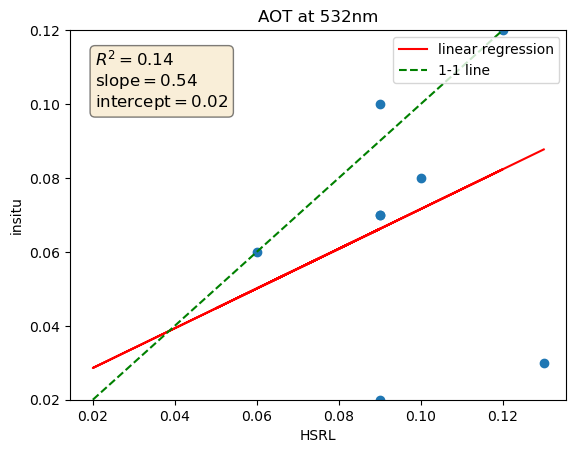

In [184]:
# Calculate the slope, intercept, and R-squared values
slope, intercept, r_value, p_value, std_err = stats.linregress(data2['HSRL'], data2['insitu'])
r_squared = r_value ** 2

# Plot the scatter plot
fig,ax = plt.subplots()
ax.scatter(data2['HSRL'], data2['insitu'])
#linear regression line
ax.plot(data2['HSRL'], slope * np.array(data2['HSRL']) + intercept, color='r', label = 'linear regression')
#plot 1-1 line
ax.plot([min(data2['HSRL']), max(data2['HSRL'])], [min(data2['HSRL']), max(data2['HSRL'])], 'k--', color='g', label = '1-1 line')
plt.legend(loc = 'upper right')
plt.xlabel('HSRL')
plt.ylabel('insitu')
plt.title('AOT at 532nm')
ax.set_ylim(0.02,0.12)

# Annotate the R-squared, slope, and intercept values
textstr = '\n'.join((
    r'$R^2=%.2f$' % (r_squared,),
    r'$\mathrm{slope}=%.2f$' % (slope,),
    r'$\mathrm{intercept}=%.2f$' % (intercept,)))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=props)

plt.show()

In [174]:
"""plt.figure(figsize=(10, 4))
# Create the scatter plot
plt.scatter(data['Time'], data['HSRL'], label = 'HSRL')
plt.scatter(data['Time'], data['insitu'], label = 'insitu')
#plt.errorbar(data['Time'], data['insitu'], data['std_insitu'], label = 'insitu_std')
#plt.errorbar(data['Time'], data['HSRL'], data['std_HSRL'], label = 'HSRL_std')


# Set labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot')
plt.tight_layout()
plt.legend()

# Display the plot
plt.show()"""


"plt.figure(figsize=(10, 4))\n# Create the scatter plot\nplt.scatter(data['Time'], data['HSRL'], label = 'HSRL')\nplt.scatter(data['Time'], data['insitu'], label = 'insitu')\n#plt.errorbar(data['Time'], data['insitu'], data['std_insitu'], label = 'insitu_std')\n#plt.errorbar(data['Time'], data['HSRL'], data['std_HSRL'], label = 'HSRL_std')\n\n\n# Set labels and title\nplt.xlabel('X-axis')\nplt.ylabel('Y-axis')\nplt.title('Scatter Plot')\nplt.tight_layout()\nplt.legend()\n\n# Display the plot\nplt.show()"

In [175]:
"""# Create the scatter plot
slope, intercept = np.polyfit(data['HSRL'], data['insitu'], 1)
line = slope * np.array(data['HSRL']) + intercept
y_fit = intercept + slope * np.array(data['HSRL'])
# Calculate R-squared value
residuals = np.array(data['insitu']) - y_fit
ss_residuals = np.sum(residuals**2)
ss_total = np.sum((np.array(data['insitu']) - np.mean(data['insitu']))**2)
r_squared = 1 - (ss_residuals / ss_total)

# Create the scatter plot
plt.scatter(data['HSRL'], data['insitu'])



# Plot the line of best fit
plt.plot(data['HSRL'], line, color='red', label='Line of Best Fit')
#plot 1-1 line
plt.plot([min(data['HSRL']), max(data['HSRL'])], [min(data['HSRL']), max(data['HSRL'])], 'k--', color='green', label='1-1 Line')



# Set labels and title
plt.xlabel('HSRL')
plt.ylabel('insitu')
plt.title('Scatter Plot')
plt.tight_layout()
plt.legend()

# Display the plot
plt.show()"""""


"# Create the scatter plot\nslope, intercept = np.polyfit(data['HSRL'], data['insitu'], 1)\nline = slope * np.array(data['HSRL']) + intercept\ny_fit = intercept + slope * np.array(data['HSRL'])\n# Calculate R-squared value\nresiduals = np.array(data['insitu']) - y_fit\nss_residuals = np.sum(residuals**2)\nss_total = np.sum((np.array(data['insitu']) - np.mean(data['insitu']))**2)\nr_squared = 1 - (ss_residuals / ss_total)\n\n# Create the scatter plot\nplt.scatter(data['HSRL'], data['insitu'])\n\n\n\n# Plot the line of best fit\nplt.plot(data['HSRL'], line, color='red', label='Line of Best Fit')\n#plot 1-1 line\nplt.plot([min(data['HSRL']), max(data['HSRL'])], [min(data['HSRL']), max(data['HSRL'])], 'k--', color='green', label='1-1 Line')\n\n\n\n# Set labels and title\nplt.xlabel('HSRL')\nplt.ylabel('insitu')\nplt.title('Scatter Plot')\nplt.tight_layout()\nplt.legend()\n\n# Display the plot\nplt.show()"

In [176]:
slope, intercept = np.polyfit(data['HSRL'], data['insitu'], deg=1)
y_fit = intercept + slope * np.array(data['HSRL'])

# Calculate R-squared value
residuals = np.array(data['insitu']) - y_fit
ss_residuals = np.sum(residuals**2)
ss_total = np.sum((np.array(data['insitu']) - np.mean(data['insitu']))**2)
r_squared = 1 - (ss_residuals / ss_total)

'''# Create the scatter plot
fig,ax = plt.subplots()
ax.scatter(data['HSRL'], data['insitu'])
# Plot the line of best fit
ax.plot(data['HSRL'], y_fit, color='red')
#plot 1-1 line
ax.plot([min(data['HSRL']), max(data['HSRL'])], [min(data['HSRL']), max(data['HSRL'])], 'k--', color='green')

# Display the intercept, slope, and R-squared values
#plt.text(4, 9, f'Intercept: {intercept:.2f}', fontsize=8)
#plt.text(4, 8.5, f'Slope: {slope:.2f}', fontsize=8)
#plt.text(4, 8, f'R-squared: {r_squared:.2f}', fontsize=8)

# Set labels and title
plt.xlabel('HSRL')
plt.ylabel('insitu')
plt.title('Linear Regression Plot')

# Add legend
plt.legend()

# Display the plot
plt.show()'''

"# Create the scatter plot\nfig,ax = plt.subplots()\nax.scatter(data['HSRL'], data['insitu'])\n# Plot the line of best fit\nax.plot(data['HSRL'], y_fit, color='red')\n#plot 1-1 line\nax.plot([min(data['HSRL']), max(data['HSRL'])], [min(data['HSRL']), max(data['HSRL'])], 'k--', color='green')\n\n# Display the intercept, slope, and R-squared values\n#plt.text(4, 9, f'Intercept: {intercept:.2f}', fontsize=8)\n#plt.text(4, 8.5, f'Slope: {slope:.2f}', fontsize=8)\n#plt.text(4, 8, f'R-squared: {r_squared:.2f}', fontsize=8)\n\n# Set labels and title\nplt.xlabel('HSRL')\nplt.ylabel('insitu')\nplt.title('Linear Regression Plot')\n\n# Add legend\nplt.legend()\n\n# Display the plot\nplt.show()"

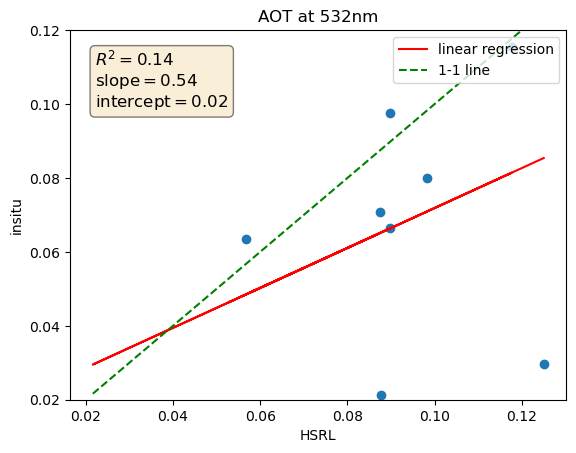

In [178]:
# Calculate the slope, intercept, and R-squared values
slope, intercept, r_value, p_value, std_err = stats.linregress(data['HSRL'], data['insitu'])
r_squared = r_value ** 2

# Plot the scatter plot
fig,ax = plt.subplots()
ax.scatter(data['HSRL'], data['insitu'])
#linear regression line
ax.plot(data['HSRL'], slope * np.array(data['HSRL']) + intercept, color='r', label = 'linear regression')
#plot 1-1 line
ax.plot([min(data['HSRL']), max(data['HSRL'])], [min(data['HSRL']), max(data['HSRL'])], 'k--', color='g', label = '1-1 line')
plt.legend(loc = 'upper right')
plt.xlabel('HSRL')
plt.ylabel('insitu')
plt.title('AOT at 532nm')
ax.set_ylim(0.02,0.12)

# Annotate the R-squared, slope, and intercept values
textstr = '\n'.join((
    r'$R^2=%.2f$' % (r_squared,),
    r'$\mathrm{slope}=%.2f$' % (slope,),
    r'$\mathrm{intercept}=%.2f$' % (intercept,)))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=props)

plt.show()